# Spectrogram Analysis Jupyter notebook

Things to consider today:

It’s publication time. Execute all Marios related tasks.

0) try to understand what is going on with the pure predictions. (they are still running, but why did only two of them begin to run? what is going on? (likely you shoul immediately run the medium dataset

1) try to clean up experiment results and fix the results.

2) 

1) Identify the joint prediction paths, automate plot production, upload all these types of plots online

2) Print out and read the article

3) prepare for meeting with Marios, prepare pure prediction, multiple kinds.

4) get ready for 3D loss plots

In [1]:
! tree final_results

final_results
├── 150_500Hz_cyclic.pickle
├── 150_500Hz_random.pickle
├── 500_900Hz_cyclic.pickle
├── 500_900Hz_random.pickle
├── block_N_Targidx_40N_Obsidx_26.pickle
└── combined_analysis.pickle

0 directories, 6 files


In [2]:
%run -i 'PyFiles/imports.py'
%run -i 'PyFiles/helpers.py'
%run -i "PyFiles/experiment.py"
%run -i "PyFiles/analysis.py"

import copy
import glob
import matplotlib
import os
from scipy.io import loadmat
import scipy.stats as stats
import sys

# to stop print output:
#def blockPrint():
#    sys.stdout = open(os.devnull, 'w')

In [11]:
def get_target_freq(experiment):
    freq_spec_lst = np.array(experiment["f"])[experiment["resp_idx"]]
    target_freq_spec = np.round(np.mean(freq_spec_lst),1)
    return(target_freq_spec)

def IdxMatch(experiment, 
             resp_idx_range = range(272, 301), 
             n_obs = 28
             ):
    """
    obs3:
    obs4: resp_idx_range = range(272, 301) n_obs = 28
    obs5:
    """
    #if obs_idx_lst == experiment["obs_idx"]:
    #    if resp_idx_lst == experiment["resp_idx"]:
    #        return True
    resp_idx_list = list(resp_idx_range)
    if resp_idx_list == experiment["resp_idx"]:
        if n_obs == len(experiment["obs_idx"]):
            return True
    return False

def freq_plot(analysis_obj, experiment_num = 0, title = "Observer 4 experiment",  save = None):
    """ 
    This function takes an EchoStateAnalysis object and creates a frequency loss plot.
    
    Arguments:
        analysis_obj: the EchoStateAnalysis object
        experiment_num: the index number of the EchoStateExperiment.
        title: the title of the experiment.
        save: the path to which to save the image.
    """
    freq_rDF = analysis_obj.rDF.copy()
    
    freq_loss_df =  freq_rDF[freq_rDF["experiment #"] == experiment_num]

    plt.figure(figsize = (12,5))
    for i, model in enumerate(np.unique(freq_loss_df.model)):
        
        freq_rDF_spec = freq_loss_df[freq_loss_df.model == model]
        mean_freq_rDF_spec = freq_rDF_spec.groupby(by = "freq").mean()
        mean_freq_rDF_spec["model"] = model
        if not i:
            mean_freq_rDF = mean_freq_rDF_spec 
        else: 
            mean_freq_rDF = pd.concat([mean_freq_rDF, mean_freq_rDF_spec], axis = 0)
    
    sns.lineplot(x = "freq", y = "L2", data = freq_loss_df, alpha = 0.9, hue = "model")
    plt.title(title, fontsize = 16)
    plt.xlabel("Frequency (Hz)", fontsize = 15)
    plt.ylabel("L2 Loss", fontsize = 15)
    if save:
        plt.savefig(save)

def time_plot(analysis_obj, experiment_num = 0, title = "Observer 4 experiment", rolling = None, save = None):
    """
    This function takes an EchoStateAnalysis object and creates a time loss plot.
    
    Arguments:
        analysis_obj: the EchoStateAnalysis object
        experiment_num: the index number of the EchoStateExperiment.
        title: the title of the experiment.
        save: the path to which to save the image.
    """
    time_rDF = analysis_obj.rDF.copy()
    time_loss_df =  time_rDF[time_rDF["experiment #"] == experiment_num]
    
    plt.figure(figsize = (12,5))
    rollings = {}
    if rolling:
        mean_ = []
        for model in np.unique(time_loss_df.model):
            print(model)
            sub_df = time_loss_df[time_loss_df.model == model]
            rollings[model]= sub_df.L2.rolling(rolling).mean()
        
        time_loss_df["rolling_L2"] = -1
        for model in np.unique(time_loss_df.model):
            time_loss_df.rolling_L2[time_loss_df.model == model] = rollings[model]
        sns.lineplot(x = "time", y = "rolling_L2", data = time_loss_df, alpha = 0.9, hue = "model" ) 
    else:
        sns.lineplot(x = "time", y = "L2", data = time_loss_df,  alpha = 0.9, hue = "model")
    lb = 0
    ub = np.percentile(time_loss_df.L2, 95)
    title = title
    plt.title(title, fontsize = 16)
    plt.xlabel("Time (seconds)", fontsize = 15)
    plt.ylabel("L2 Loss", fontsize = 15)
    sns.despine()
    if save:
        plt.savefig(save)
        
def prediction_plot(analysis_obj, experiment_num = 0, title = "Observer 4 experiment", rolling = None, save = None):
    time_rDF = analysis_obj.rDF.copy()
    time_loss_df =  time_rDF[time_rDF["experiment #"] == experiment_num]
    plt.figure(figsize = (12,5))
    rollings = {}
    if rolling:
        mean_ = []
        
        for model in np.unique(time_loss_df.model):
            print(model)
            sub_df = time_loss_df[time_loss_df.model == model]
            rollings[model]= sub_df.L2.rolling(rolling).mean()
        
        time_loss_df["rolling_L2"] = -1
        for model in np.unique(time_loss_df.model):
            time_loss_df.rolling_L2[time_loss_df.model == model] = rollings[model]
        sns.lineplot(x = "time", y = "rolling_L2", data = time_loss_df, alpha = 0.9, hue = "model" ) 
    else:
        sns.lineplot(x = "time", y = "L2", data = time_loss_df,  alpha = 0.9, hue = "model")
    lb = 0
    ub = np.percentile(time_loss_df.L2, 95)
    title = title
    plt.title(title, fontsize = 16)
    plt.xlabel("Time (seconds)", fontsize = 15)
    plt.ylabel("L2 Loss", fontsize = 15)
    sns.despine()
    if save:
        plt.savefig(save)
        
    
#pickle_A.experiment_lst[0] = pickle_zhizhuo.experiment_lst[0] 
def quick_plot(n, analysis, outfile = None ):
    
    if type(analysis) != list:
        analysis = [analysis]
    
    #only save the plot if requested.
    if outfile:
        save_path = "fig/" + outfile 
        save_path_time = save_path + "_freq"
        save_path_freq = save_path + "_time"
    else:
        save_path_time, save_path_freq  = None, None
        outfile = ""
    for i, analysis_ in enumerate(analysis):
        models = list(analysis_.experiment_lst[0]["nrmse"].keys())
        
        analysis_.build_loss_df(group_by = "freq", models = models,  columnwise = False) #models = ["cyclic","ip: linear"]
        analysis_.build_loss_df(group_by = "time", models = models, columnwise = False)
        freq_plot(analysis_, n, title = outfile + " Avg. L2 Loss vs Frequency", save = save_path_freq)
        time_plot(analysis_, experiment_num = n, rolling = 150, save = save_path_time,
              title = outfile + " Avg. L2 Loss vs Time (rolling average)")
    return analysis[0].rDF


In [12]:
! ls experiment_results/publish/split_0.5

block_N_Targidx_1N_Obsidx_4.pickle
block_N_Targidx_40N_Obsidx_26.pickle
block_N_Targidx_40N_Obsidx_50.pickle
block_cyclicN_Targidx_1N_Obsidx_4.pickle
block_cyclicN_Targidx_40N_Obsidx_26.pickle
block_cyclicN_Targidx_40N_Obsidx_50.pickle
block_cyclictargetHz_ctr:_1000targetKhz:_0.006__obskHz:_0.01.pickle
block_cyclictargetHz_ctr:_1000targetKhz:_0.006__obskHz:_0.05.pickle
block_cyclictargetHz_ctr:_998targetKhz:_1.0__obskHz:_1.0.pickle
block_cyclictargetHz_ctr:_999targetKhz:_0.025__obskHz:_0.05.pickle
block_cyclictargetHz_ctr:_999targetKhz:_0.1__obskHz:_0.25.pickle
block_cyclictargetHz_ctr:_999targetKhz:_0.5__obskHz:_1.0.pickle
block_targetHz_ctr:_999targetKhz:_0.1__obskHz:_0.1.pickle
block_targetHz_ctr:_999targetKhz:_0.1__obskHz:_0.25.pickle
block_targetHz_ctr:_999targetKhz:_0.5__obskHz:_0.5.pickle
block_targetHz_ctr:_999targetKhz:_0.5__obskHz:_1.0.pickle
targetHz_ctr:_1000targetKhz:_0.005__obskHz:_0.007.txt
targetHz_ctr:_989targetKhz:_0.08__obskHz:_0.08.txt
targetHz_ctr:_989targetKhz:_0.

In [13]:
#rand_path = 'final_results/*random.pickle'
rand_path = 'experiment_results/publish/split_0.5/block_target*.pickle'
COMBINED_ANALYSIS_NOT_LOADED = True
if COMBINED_ANALYSIS_NOT_LOADED:
    random_path_list = glob.glob(rand_path)
    print(random_path_list)

    random_expers = EchoStateAnalysis(random_path_list, model = "uniform",
                                  ip_use_observers = True, ip_method = "linear")

['experiment_results/publish/split_0.5/block_targetHz_ctr:_999targetKhz:_0.1__obskHz:_0.1.pickle', 'experiment_results/publish/split_0.5/block_targetHz_ctr:_999targetKhz:_0.5__obskHz:_0.5.pickle', 'experiment_results/publish/split_0.5/block_targetHz_ctr:_999targetKhz:_0.5__obskHz:_1.0.pickle', 'experiment_results/publish/split_0.5/block_targetHz_ctr:_999targetKhz:_0.1__obskHz:_0.25.pickle']


['interpolation', 'uniform']
['interpolation', 'uniform']



unif
EXP
unif
EXP

the following paths have not yet been run: 
['experiment_results/publish/split_0.5/block_targetHz_ctr:_999targetKhz:_0.5__obskHz:_0.5.pickle'
 'experiment_results/publish/split_0.5/block_targetHz_ctr:_999targetKhz:_0.5__obskHz:_1.0.pickle']
[]
[]
total experiments completed: 2
total experiments half complete: 0
total experiments not yet run: 2
Percentage of tests completed: 50.0%



exponential
ip: linear
uniform



exponential
ip: linear
uniform


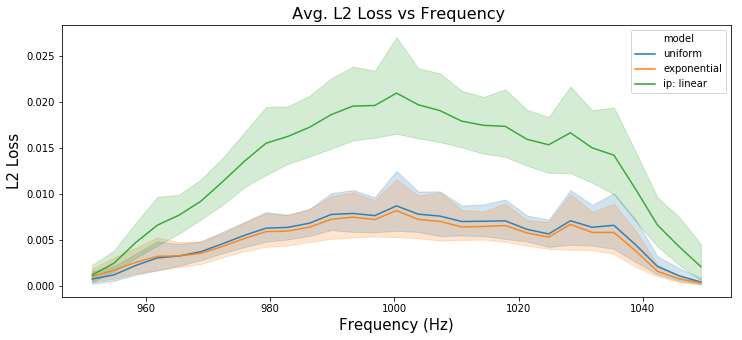

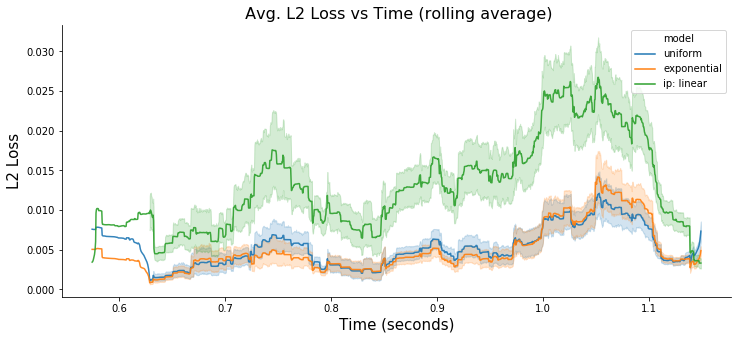

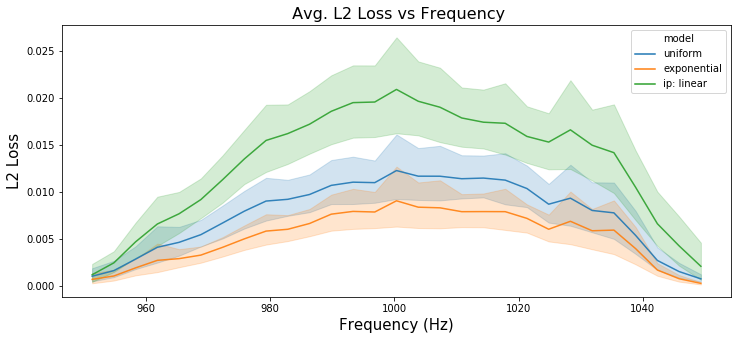

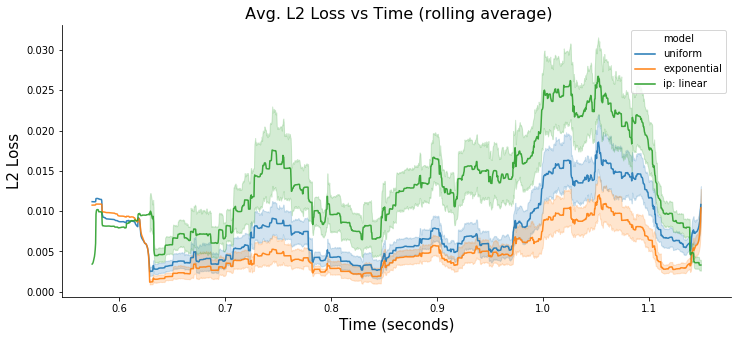

In [14]:
for i in range(len(random_expers.experiment_lst)):
    quick_plot(i, random_expers)

In [15]:
rand_path = 'final_results/*random.pickle'
#rand_path = 'experiment_results/publish/split_0.5/block_target*.pickle'
COMBINED_ANALYSIS_NOT_LOADED = True
if COMBINED_ANALYSIS_NOT_LOADED:
    random_path_list = glob.glob(rand_path)
    print(random_path_list)

    random_expers = EchoStateAnalysis(random_path_list, model = "uniform",
                                  ip_use_observers = True, ip_method = "linear")

['final_results/500_900Hz_random.pickle', 'final_results/150_500Hz_random.pickle']


unif
EXP
unif
EXP

[]
[]
total experiments completed: 2
total experiments half complete: 0
total experiments not yet run: 0
Percentage of tests completed: 100.0%


In [ ]:
for i in range(len(random_expers.experiment_lst)):
    quick_plot(i, random_expers)


exponential
ip: linear
uniform


In [ ]:
COMBINED_ANALYSIS_NOT_LOADED = True
if COMBINED_ANALYSIS_NOT_LOADED:
    dl_path_list = glob.glob('final_results/*cyclic.pickle')

    dl_path_list = ["final_results/500_900Hz_cyclic.pickle",
                    "final_results/150_500Hz_cyclic.pickle",
                   "experiment_results/publish/split_0.5/block_cyclictargetHz_ctr:_999targetKhz:_0.1__obskHz:_0.25.pickle",
                   "experiment_results/publish/split_0.5/block_cyclictargetHz_ctr:_999targetKhz:_0.5__obskHz:_1.0.pickle"]#"experiment_results/publish/split_0.5/block_cyclicN_Targidx_40N_Obsidx_26.pickle"]
    dl_expers = EchoStateAnalysis(dl_path_list, model = "cyclic",
                                  ip_use_observers = True, ip_method = "linear")

In [ ]:
for i in range(len(dl_expers.experiment_lst)):
    quick_plot(i, dl_expers)

In [ ]:
dl_expers

In [ ]:
! ls experiment_results/publish/split_0.5
#targetHz_ctr
#block_targetHz
#block_cyclictargetHz
#block_N_Targidx_
#block_DLtargetHz

In [ ]:
#dl_expers.hyper_parameter_plot()
if COMBINED_ANALYSIS_NOT_LOADED:
    #check out whats what
    n = 0
    hi = [dl_expers, random_expers]
    quick_plot(n, hi)


In [ ]:
def recursive_dict_combine(exper1, exper2):
    for key1, value1 in exper1.items():
        if type(exper1[key1]) == dict:
            #print(key1)
            exper1[key1] = {**exper1[key1], **exper2[key1]}
            #print(exper1[key1])
    return exper1
def analysis_combine(analysis1, analysis2, n):
    for i, exper in enumerate(analysis1.experiment_lst):
        print(i)
        analysis1.experiment_lst[i] = recursive_dict_combine(dl_expers.experiment_lst[i], 
                                                             random_expers.experiment_lst[i])
    return(analysis1)
if COMBINED_ANALYSIS_NOT_LOADED:
    combined_analysis = analysis_combine(dl_expers, random_expers, 0)


In [ ]:
#save the combined analysis:
#import pickle

a = {'combined_analysis': combined_analysis}

with open('final_results/combined_analysis.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
if not COMBINED_ANALYSIS_NOT_LOADED:
    with open('final_results/combined_analysis.pickle', 'rb') as handle:
        combined_analysis = pickle.load(handle)["combined_analysis"]

In [ ]:

quick_plot(0, combined_analysis
           , outfile = "500_900Hz")

In [ ]:
quick_plot(1, combined_analysis, outfile = "150_500Hz")

In [ ]:
combined_analysis.hyper_parameter_plot()

### Delay Line: Reservoir

In [ ]:
#np.full((3,3), fill_value = 1)
cyclic_weight = 1
n_nodes = 10

weights = np.zeros((n_nodes, n_nodes), dtype=np.int32) #np.float32)
#weights[0, -1] = cyclic_weight <-- This is the only difference between the cyclic reservoir and the delay line.
for i in range(n_nodes - 1):
    #weights[i + 1, i] = cyclic_weight
    weights[i+1, i] = cyclic_weight
#weights[0, ]
pd.DataFrame(weights)
plt.imshow(weights)
plt.xlabel("N: Number of Nodes")
plt.ylabel("N: Number of Nodes")
plt.title("Reservoir Weights")
plt.colorbar()

In [ ]:
#np.full((3,3), fill_value = 1)
cyclic_weight = 1
n_nodes = 10

weights = np.zeros((n_nodes, n_nodes), dtype=np.int32) #np.float32)
#weights[0, -1] = cyclic_weight <-- This is the only difference between the cyclic reservoir and the delay line.
for i in range(n_nodes - 1):
    #weights[i + 1, i] = cyclic_weight
    weights[i+1, i] = cyclic_weight
weights[0, -1] = cyclic_weight
pd.DataFrame(weights)
plt.imshow(weights)
plt.xlabel("N: Number of Nodes")
plt.ylabel("N: Number of Nodes")
plt.title("Cylic Reservoir Weights")
plt.colorbar()

In [ ]:
n = 10
connectivity = 0.2
spectral_radius = 0.99

accept = np.random.uniform(size = (n, n)) < connectivity

weights = np.random.uniform( -1., 1., size = (n, n))
weights *= accept
max_eigenvalue = np.abs( np.linalg.eigvals( weights)).max()


# Set spectral radius of weight matrix
weights *= spectral_radius / max_eigenvalue
plt.imshow(weights)
plt.xlabel("N: Number of Nodes")
plt.ylabel("N: Number of Nodes")
plt.title("Random Reservoir Weights")
plt.colorbar()

In [ ]:
beta = 100
alpha = 50
n_nodes = 10
n_inputs = 10
orig_inputs = np.random.uniform(-1, 1, size = 4)

input_bias = np.full((n_nodes,1), fill_value = alpha)

input_weights = np.full((1,n_inputs), fill_value = beta)
input_weights_zeroes = np.zeros((n_nodes -1, n_inputs))

input_weights = np.vstack((input_weights, input_weights_zeroes))
input_weights = np.hstack((input_bias, input_weights))
plt.imshow(input_weights, aspect = 0.5)
plt.xlabel("M: number of inputs")
plt.ylabel("N: number of Nodes")
plt.title("Delay Line Input Weights")
plt.colorbar()
inputs = np.hstack((1, orig_inputs))
print(inputs)
print(alpha + np.sum(orig_inputs)*beta)
input_weights @ inputs.T

In [ ]:
def sin_sq(arr):
    temp = np.sin(arr)
    return(temp**2)
sin_sq(inputs)

## Legitimate Delay line. The only output is a single number for the first node of the Rc.

In [ ]:
beta = 100
alpha = 50
n_nodes = 10
n_inputs = 6
input_bias = np.full((1,), fill_value = alpha)
input_weights = np.full((n_inputs,), fill_value = beta)

input_weights = np.hstack((input_bias, input_weights))
input_weights_zeroes = np.zeros((n_nodes-1, n_inputs + 1))

input_weights = np.vstack((input_weights, input_weights_zeroes))
print("Input Weights (bias = 1, beta = 100)")
display(input_weights)
plt.imshow(input_weights, aspect = 0.5)
plt.xlabel("M: number of inputs")
plt.ylabel("N: number of Nodes")
plt.title("Delay Line Input Weights")
plt.colorbar()
orig_inputs = np.random.uniform(-1, 1, size = n_inputs)
inputs = np.hstack((1, orig_inputs))
print("")
print("Inputs")
print(inputs)
print(alpha + np.sum(orig_inputs)*beta)
print("")
print("Output")
display(input_weights @ inputs.T)

In [ ]:
beta = 100
alpha = 50
n_nodes = 10
n_inputs = 6
input_bias = np.full((1,), fill_value = alpha)
input_weights = np.full((n_inputs,), fill_value = beta)

input_weights = np.hstack((input_bias, input_weights))
input_weights_zeroes = np.zeros((n_nodes-1, n_inputs + 1))

input_weights = np.random.uniform(-1, 1, size = (n_nodes, n_inputs))
#print("Input Weights (bias = 1, beta = 100)")
#display(input_weights)
plt.imshow(input_weights, aspect = 0.5)
plt.xlabel("M: number of inputs")
plt.ylabel("N: number of Nodes")
plt.title("Random Input Weights (cyclic, uniform, exponential)")
plt.colorbar()
orig_inputs = np.random.uniform(-1, 1, size = n_inputs)
inputs = np.hstack((1, orig_inputs))
print("")
print("Inputs")
print(inputs)
print(alpha + np.sum(orig_inputs)*beta)
print("")
print("Output")

### Delay Line input weights

In [ ]:
!ls experiment_results/medium/split_0.5

## Pure Prediction 2.0
The key to the pure prediction is to break it down. We are going to take in a parameter k, which is the maximum time-series to include in a block prediction. Then we will break the target matrix A into component sections.

This will simply require an appropriate series. The next step is to develop an appropriate method for combining the different matrices.

There can be two options: overlapping and not overlapping. If there are over-lapping predictions we take a simple average. Otherwise we simply combine them.

In [ ]:
! ls spectrogram_data/medium


In [ ]:
A_med = loadmat('spectrogram_data/medium/Intensity_1024.mat')["M"]
plt.imshow(A_med)
plt.show()
A_med = A_med.T
plt.imshow(A_med)

In [ ]:
#zhizhuo experiment 1: finding the right indices ; 249, 289
lst__ = [i for i in list(range(250 - 1, 289))]
assert len(lst__) == 40
assert lst__[0] + 1 == 250
assert lst__[-1] + 1 == 289
print(len(lst__))
print(lst__[0] + 1)
print(lst__[-1] + 1)

In [ ]:
#250-289 inclusive
def get_series(matrixx, k, zhizhuo_endpoints = None, shape_assert = None, plott = False, start = 0):
    matrixx = (matrixx - np.mean(matrixx)) / np.std(matrixx)
    #start = 0
    stop = matrixx.shape[1]
    print("stop: " + str(stop))
    break_points = range(start, stop, k)
    break_points = list(break_points)
    if zhizhuo_endpoints:
        zlb, zub = zhizhuo_endpoints[0], zhizhuo_endpoints[1]
    
    train_arrays  = []
    target_arrays = []
    
    #### --> test area
    if plott:
        fig, ax = plt.subplots(1, len(break_points) - 1, figsize = (8, 12))
    for i in range(len(break_points) - 1):
        lb, ub = break_points[i], break_points[i+1]
        if zhizhuo_endpoints:
            sub_df = matrixx[ zlb:zub, lb:ub]
            sub_df_train = matrixx[ (zlb - 100):zlb, lb:ub]
            train_arrays.append(sub_df_train)
            target_arrays.append(sub_df)
            if plott:
                ax[i].imshow(sub_df, aspect = 10)
            if shape_assert:
                assert( shape_assert == sub_df.shape[0])
        else:
            ax[i].imshow(matrixx[:,lb:ub], aspect = 1)
            target_arrays.append(matrixx[:,lb:ub])
    if plott:
        plt.show()
    print(len(train_arrays))
    
    dictt = {"Train" :[np.ones(arr.shape) for arr in train_arrays] , 
             "xTr" : train_arrays,
             "target" :  [np.ones(arr.shape) for arr in target_arrays], #np.ones(self.xTr.shape), np.ones(self.xTe.shape)
             "xTe" : target_arrays }
    return dictt
# The question is obvious,

In [ ]:
broken_up_A_med = get_series(A_med, k = 1, 
                             zhizhuo_endpoints = [249, 289], 
                             shape_assert = 40, start = 5)


In [ ]:
plt.imshow(broken_up_A_med["xTr"][0], aspect = 0.5)
plt.show()
plt.imshow(broken_up_A_med["xTe"][0], aspect = 0.5)
print(broken_up_A_med["xTr"][0].shape)
print(broken_up_A_med["xTe"][0].shape)

In [ ]:
Train = broken_up_A_med["Train"][0]
print(Train.shape)
xTr = broken_up_A_med["xTr"][0]
plt.imshow(xTr)

In [ ]:
broken_up_A_med["xTe"][0].shape

In [ ]:
bounds = { 'connectivity':    (-3, 0),
            'n_nodes':   1000,
            'spectral_radius': (0.001, 0.999),
            'regularization':  (-6, 4),
            "leaking_rate" :   (0.001, 1)}
esn_cv_spec = EchoStateNetworkCV(bounds = bounds, 
                                 subsequence_length = 40, 
                                 esn_feedback = False, 
                                 eps = 10**(-5),
                                 cv_samples = 3,
                                 model_type = "uniform",
                                 n_jobs = 2,
                                 initial_samples = 150
                                )
assert broken_up_A_med["Train"][0].shape == broken_up_A_med["xTr"][0].shape
best_args_ = esn_cv_spec.optimize(y = xTr, x = None)#np.ones(xTr.shape))
#self.best_arguments =  self.esn_cv.optimize(x = self.Train, y = self.xTr) 

In [ ]:
hi = """best_args_ = {'cyclic_res_w': 0.001246639973578002,
              'cyclic_input_w': 0.018582012103828045,
              'cyclic_bias': 0.050674025611653906,
              'leaking_rate': 0.001,
              'n_nodes': 1000,
              'random_seed': 123,
              'feedback': False,
              "model_type" : "cyclic"}
best_args_ = {'connectivity': 1.0,
 'spectral_radius': 0.5420020711421967,
 'regularization': 1.367683798343926,
 'leaking_rate': 1.0,
 'n_nodes': 1000,
 'random_seed': 123,
 'feedback': False,
 'model_type' : "uniform"}"""
best_args_ = {'cyclic_res_w': 0.001246639973578002,
              'cyclic_input_w': 0.018582012103828045,
              'cyclic_bias': 0.050674025611653906,
              'leaking_rate': 0.001,
              'n_nodes': 1000,
              'random_seed': 123,
              'feedback': False,
              "model_type" : "cyclic"}


esn_spec =  EchoStateNetwork(**best_args_)#, model_type = "uniform")

In [ ]:
print(broken_up_A_med["xTr"][0].shape)
print(np.ones(broken_up_A_med["xTr"][0].shape).shape)
broken_up_A_med.keys()

In [ ]:
broken_up_A_med["target"][0].shape
type(broken_up_A_med["Train"][0])

In [ ]:
test_ = broken_up_A_med["xTe"][0]
xTr, xTe = broken_up_A_med["xTr"][0], broken_up_A_med["xTe"][0]
plt.imshow(test_)

print(broken_up_A_med.keys())
plt.imshow(broken_up_A_med["xTr"][0], aspect = 0.2)
esn_spec.train(y = broken_up_A_med["xTr"][0],  x = None)
pred_ = esn_spec.predict( n_steps = test_.shape[0], x = broken_up_A_med["target"][0])

In [ ]:
#plt.imshow(broken_up_A_med["xTr"][0])
sns.heatmap(broken_up_A_med["Train"][0])

In [ ]:
print(nrmse(test_, pred_))
plt.imshow(pred_)
plt.show()
plt.imshow(test_)
plt.show()

In [ ]:
#enablePrint()
pickle_list = glob.glob('experiment_results/publish/*/*.pickle')
pickle_list = pickle_list[1:]
print(pickle_list)

#### check if path list has duplicates.

In [ ]:
assert len(pickle_list) == len(list(np.unique(pickle_list)))

In [ ]:

pickle_A = EchoStateAnalysis(pickle_list, model = "uniform", ip_use_observers = True, ip_method = "linear")

### The following helper functions are assisting me to accomplish getting the final figures.

In [ ]:
pickle_A = dl_expers

In [ ]:
target_freqs = []
for i, experiment in enumerate(pickle_A.experiment_lst):
    tf = get_target_freq(experiment)
    target_freqs.append(tf)
    #print(experiment["resp_idx"])
    if IdxMatch(experiment):
        freq_plot(pickle_A, experiment_num = i)
    if IdxMatch(experiment, n_obs = 96):
        freq_plot(pickle_A, experiment_num = i)
target_freqs


#### Add Zhizhuo Data

In [ ]:

def add_zhizhuo_data(analysis_obj_, experiment_num):
    analysis_obj = copy.copy(analysis_obj_)#.copy()
    obs4_yhat = loadmat('/Users/hayden/Desktop/ytesthat_ob4.mat')
    zhizhuo_rez = obs4_yhat["ytesthat_ob4"]
    zhizhuo_rez = zhizhuo_rez.T
    zhizhuo_rez = np.flip(zhizhuo_rez, axis = 1)
    plt.imshow(zhizhuo_rez, aspect = 0.05)
    #0 is zhizhuo_test
    for n in [experiment_num]:
        #hi = analysis_obj.get_experiment(analysis_obj.experiment_lst[n])
        analysis_obj.model = "uniform"

        exper_unif = analysis_obj.get_experiment(analysis_obj.experiment_lst[n])

        unif_nrmse = nrmse(exper_unif.prediction, exper_unif.xTe)
        analysis_obj.experiment_lst[n]["prediction"]["uniform"] = exper_unif.prediction
        analysis_obj.experiment_lst[n]["nrmse"]["uniform"] = unif_nrmse

        zhizhuo_nrmse = nrmse(zhizhuo_rez, exper_unif.xTe)
        analysis_obj.experiment_lst[n]["prediction"]["zhizhuo"] = zhizhuo_rez
        analysis_obj.experiment_lst[n]["nrmse"]["zhizhuo"] = zhizhuo_nrmse

        #nrmse(exper_unif.prediction, exper_unif.xTe)
        analysis_obj.model = "exponential"
        exper_exp = analysis_obj.get_experiment(analysis_obj.experiment_lst[n])
        print(n)
        exper_exp.model = "exponential"
        exp_nrmse = nrmse(exper_exp.prediction, exper_exp.xTe)

        analysis_obj.experiment_lst[n]["prediction"]["exponential"] = exper_exp.prediction
        analysis_obj.experiment_lst[n]["nrmse"]["exponential"] = exp_nrmse
        analysis_obj.model = "uniform"
    print("")
    return analysis_obj
pickle_zhizhuo = add_zhizhuo_data(pickle_A, 0)
pickle_zhizhuo.experiment_lst = [pickle_zhizhuo.experiment_lst[0]]
pickle_zhizhuo.build_loss_df(group_by = "freq", models = ["uniform", "exponential", "zhizhuo", "ip: linear"], columnwise = False)
pickle_zhizhuo.build_loss_df(group_by = "time", models = ["uniform", "exponential", "zhizhuo", "ip: linear"], columnwise = False)


In [ ]:
pickle_zhizhuo.build_loss_df(group_by = "freq", models = ["uniform", "exponential", "zhizhuo", "ip: linear"], columnwise = False)
pickle_zhizhuo.build_loss_df(group_by = "time", models = ["uniform", "exponential", "zhizhuo", "ip: linear"], columnwise = False)

pickle_A.experiment_lst[0] = pickle_zhizhuo.experiment_lst[0] 
freq_plot(pickle_zhizhuo, 0, title = "Observer 4 experiment: Avg. L2 Loss vs Frequency", save = "obs_4_freq")
time_plot(pickle_zhizhuo, experiment_num = 0, rolling = 150, save = "obs_4_time",
          title = "Observer 4 experiment: Avg. L2 Loss vs Time (rolling average)")

In [ ]:
def get_plots(experiment_num):
    print("experiment number: " + str(experiment_num))
    experiment = pickle_A.experiment_lst[experiment_num]
    print("target_freq: " + str(get_target_freq(experiment)))
    print("n observers: " + str(len(experiment["obs_idx"])))
    #print(experiment["resp_idx"])
    freq_plot(pickle_A, experiment_num = experiment_num, 
              title = "low Frequency experiment: " + "loss vs freq")
    time_plot(pickle_A, experiment_num = experiment_num, rolling = 150, 
              title = "low Frequency experiment: " + "time vs freq")
get_plots(1)

In [ ]:
freq_plot(pickle_A, 1, title = "Low Frequency experiment: Avg. L2 Loss vs Frequency", save = "low_freq_freq")
time_plot(pickle_A, experiment_num = 1, rolling = 150, save = "low_freq_time",
          title = "Low Frequency experiment: Avg. L2 Loss vs Time (rolling average)")

In [ ]:
resp_idx = pickle_A.experiment_lst[1]["resp_idx"]
print(resp_idx)
f = np.array(pickle_A.experiment_lst[1]["f"])
f[resp_idx]

In [ ]:
freq_plot(pickle_A, 2, title = "Rena experiment: Avg. L2 Loss vs Frequency", save = "Rena_freq")
time_plot(pickle_A, experiment_num = 2, rolling = 150, save = "Rena_time",
          title = "Rena experiment: Avg. L2 Loss vs Time (rolling average)")

In [ ]:
for i in range(3, len(pickle_A.experiment_lst)):
    get_plots(i)

In [ ]:
pickle_A.hyper_parameter_plot()

In [ ]:
for i in range(len(pickle_A.experiment_lst)):
    freq_plot(pickle_A, i)
    time_plot(pickle_A, experiment_num = i, rolling = 150)

In [ ]:
pickle_A.make_R_barplots()

In [ ]:
pickle_rDF = pickle_A.rDF_time
plt.figure(figsize = (16,8))
pickle_loss_df_50_50_split =  pickle_rDF[pickle_rDF.split == 0.5]
#pickle_loss_df_50_50_split = pickle_loss_df_50_50_split[pickle_loss_df_50_50_split.model != "exponential"]

mean_ =  pickle_loss_df_50_50_split.R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = pickle_loss_df_50_50_split["L2_loss"], data = pickle_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = pickle_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)
plt.title("block_N_Targidx_40N_Obsidx_26")

In [ ]:
pickle_rDF = pickle_A.rDF
plt.figure(figsize = (16,8))
pickle_loss_df_50_50_split =  pickle_rDF[pickle_rDF.split == 0.7]
#pickle_loss_df_50_50_split = pickle_loss_df_50_50_split[pickle_loss_df_50_50_split.model != "exponential"]

mean_ =  pickle_loss_df_50_50_split.R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = pickle_loss_df_50_50_split["R"], data = pickle_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = pickle_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)
plt.title("block_N_Targidx_40N_Obsidx_26")

In [ ]:
pickle_rDF = pickle_A.rDF
plt.figure(figsize = (16,8))
pickle_loss_df_50_50_split =  pickle_rDF[pickle_rDF.split == 0.9]
#pickle_loss_df_50_50_split = pickle_loss_df_50_50_split[pickle_loss_df_50_50_split.model != "exponential"]

mean_ =  pickle_loss_df_50_50_split.R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = pickle_loss_df_50_50_split["R"], data = pickle_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = pickle_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)
plt.title("block_N_Targidx_40N_Obsidx_26")

In [ ]:

def make_pretty_pics(experiment_number = 0, 
                     modelz = ["ip: linear", "uniform",  "exponential"], #"zhizhuo",
                    show_images = False, show_residuals = False
                    ):
    #blockPrint()
    if experiment_number == 0:
        zhizhuo_label = "obs4"
    elif experiment_number == 4:
        zhizhuo_label = "obs5"
    else:
        zhizhuo_label = "experiment " + str(experiment_number)
        
    if experiment_number == 0:
        zhizhuo_label = "low frequency"
    
    spec = pickle_A.experiment_lst[experiment_number]
    f =  spec["f"]
    freqs_dict = { idx : f[idx] for idx in spec["obs_idx"]}
    freqs_ = [f[idx] for idx in spec["resp_idx"]]
    
    truth = spec["xTe"]
    if show_images:
        plt.imshow(truth, aspect = 0.01)
        plt.title("Ground truth")
        plt.show()
        fig, ax = plt.subplots(2,2, figsize = (12, 6))
        ax = ax.flatten()
        for i, model in enumerate(modelz):

            ax[i].imshow(spec["prediction"][model], aspect = 0.01)
            ax[i].set_title(model)
        plt.tight_layout()
        
    nrmses = []
    
    #for i, model in enumerate(modelz):
        
    residuals = []
    for i, model in enumerate(modelz):
        pred_ = spec["prediction"][model]
        #if model == "zhizhuo":
        #    pred_ = np.flip(pred_, axis = 1)
        nrmse_spec = nrmse(pred_, truth)
        nrmses.append({model : nrmse_spec})
        residuals.append(np.abs(truth - pred_))
        
    if show_residuals:
        fig, ax = plt.subplots(2,2, figsize = (12, 6))
        ax = ax.flatten()
        for i, model in enumerate(modelz):
            sns.heatmap(residuals[i], ax = ax[i])
            ax[i].set_title(model + " residuals^2, R: " + str(round(nrmse_spec, 5)))
        plt.tight_layout()
        plt.show()
        
    palette_ = dict(zip(modelz, sns.color_palette("tab10")[0:4]))
    # = {"uniform": "C0", "best interpolation": "C1", "zhizhuo": "C2", "expoenential": "k"}
    
    nrmse_df = pd.DataFrame(nrmses)
    nrmse_df = nrmse_df.melt()
    nrmse_df.columns = ["model", "R"]
    nrmse_df = nrmse_df.sort_values(by='R', ascending=True)
    
    modelz_ord = list(nrmse_df.model.values)
    
    #barplot
    #fig, ax = plt.subplots(1,1, figsize = (12, 6.5))
    display(nrmse_df)
    plt.figure(figsize=(6,5))
    barplot = sns.barplot(x = "model", y = "R", data = nrmse_df, palette = palette_)
    #pal.as_hex()
    plt.title("RMSE for " + zhizhuo_label)
    plt.xticks(rotation=60)
    plt.savefig('obs5_R.png')
    plt.show()
    
    
make_pretty_pics(0, show_residuals = True)

# serious problem: experiments are getting duplicated

In [ ]:
for i in pickle_A.experiment_lst:
    spec = i["resp_idx"]
    
    if len(spec) > 1:
        exp_resp_lst = (spec)
        exp_f = i.keys()
        print(exp_f)

In [ ]:
from os.path import dirname, join as pjoin
import scipy.io as sio
new_f = sio.loadmat("/Users/hayden/Desktop/f_new.mat")
new_f = new_f["f"]

freq_imp = [list(new_f[idx])[0] for idx in exp_resp_lst]

In [ ]:
new_f[exp_resp_lst[-1] +13]

In [ ]:
R_results_df = pickle_A.R_results_df
R_results_df_rel = pickle_A.R_results_df_rel
R_results_df["experiment"] = [0,1,2] * 2
R_results_df_rel = R_results_df_rel[R_results_df_rel["model"] != "interpolation"]
R_results_df_rel["experiment"] = [0,1,2] * 2
display(R_results_df_rel)

In [ ]:
sns.barplot(x = "model", y = "R", data = R_results_df_rel)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (14, 15))
ax = ax.flatten()
print(ax)

for i in range(2):
    
    R_df_spec = R_results_df[R_results_df.experiment == i]
    R_df_rel_spec = R_results_df_rel[R_results_df_rel.experiment == i]
    
    #sns.barplot(x = "model", y = "R", data = R_df_spec)#, ax=ax[0])
    R_df_spec =R_df_spec.drop(columns = "experiment")
    R_df_rel_spec =R_df_rel_spec.drop(columns = "experiment")
    
    #sns.violinplot(x = "model", y = "R", data = self.R_results_df_rel, ax=ax[1])
    sns.barplot(x = "model", y = "R", data = R_df_spec, ci = None, ax=ax[2*i])
    
    sns.barplot(x = "model", y = "R", data = R_df_rel_spec, ci = None, ax=ax[2*i+1])


In [ ]:
pickle_rDF = pickle_A.rDF
plt.figure(figsize = (16,8))
pickle_loss_df_50_50_split =  pickle_rDF[pickle_rDF.split == 0.9]
#pickle_loss_df_50_50_split = pickle_loss_df_50_50_split[pickle_loss_df_50_50_split.model != "exponential"]

mean_ =  pickle_loss_df_50_50_split.R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = pickle_loss_df_50_50_split["R"], data = pickle_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = pickle_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)
plt.title("block_N_Targidx_40N_Obsidx_26")

## Play with asymmetric experiment.py

In [ ]:
%run -i 'PyFiles/imports.py'
%run -i 'PyFiles/helpers.py'
%run -i "PyFiles/experiment.py"
%run -i "PyFiles/analysis.py"
import scipy.stats as stats
import glob

In [ ]:
medium_path_list = glob.glob('experiment_results/medium/*/*.txt')
test_analysis = EchoStateAnalysis([medium_path_list[0]], 
                                  model = "uniform", 
                                  ip_use_observers = True, 
                                  ip_method = "linear")



In [ ]:
json_obj_test = test_analysis.experiment_lst[0]
test_experiment = test_analysis.get_experiment(json_obj_test)

In [ ]:
json_obj_test["best arguments"]

In [ ]:
test_esn = test_experiment.esn_spec
test2_esn = EchoStateNetwork(**json_obj_test["best arguments"]["exponential"],
                             resp_idx = json_obj_test["resp_idx"],
                             obs_idx = json_obj_test["obs_idx"],
                             exponential = False, plot = True, 
                             llambda2 = 10**(-2))
test2_esn.noise = 0.5
test2_esn.get_exp_weights()

In [ ]:
hi = np.array([[16,16,17,18], [15,15,15,15]])
np.hstack((hi, np.array([[2],[2]])))
# {'llambda': 0.00938595717962852, 'llambda2': 0.002908498759116776, 'connectivity': 1.0, 'spectral_radius': 0.48154601180553436, 'regularization': 0.3676013152573216, 'leaking_rate': 0.7179883186221123, 'noise': 1.2589254117941673, 'n_nodes': 1000, 'random_seed': 123}


In [ ]:
test2_esn.exp_weights.shape
test2_esn.obs_idx

In [ ]:
test_esn = test_experiment.esn_spec
test2_esn = EchoStateNetwork(**json_obj_test["best arguments"]["exponential"],
                             resp_idx = json_obj_test["resp_idx"],
                             obs_idx = json_obj_test["obs_idx"],
                             exponential = False, plot = True, dual_lambda = True, 
                             llambda2 = 0.0001)
test2_esn.noise = 0.1
test2_esn.get_exp_weights()

In [ ]:
test_esn = test_experiment.esn_spec
test2_esn = EchoStateNetwork(**json_obj_test["best arguments"]["exponential"],
                             resp_idx = json_obj_test["resp_idx"],
                             obs_idx = json_obj_test["obs_idx"],
                             exponential = False, plot = True, dual_lambda = True, 
                             llambda2 = 10)
test2_esn.noise = 0.5
test2_esn.get_exp_weights()

In [ ]:
np.random.uniform(-1, 1, size=(10, 3))
np.random.

In [ ]:
normal_error = np.random.normal(loc = 0, scale = 0.01, size = (10,3))
normal_error

In [ ]:
exp_weights1to3 = test2_esn.exp_weights[:3]
print(exp_weights1to3 )
exp_weights1to3 + normal_error

In [ ]:
np.random.choice([-1, 1], (3,3))

# Examining new pickle results

In [ ]:
".pickle" in 'experiment_results/publish/split_0.5/block_N_Targidx_1N_Obsidx_4.pickle'

In [ ]:
pickle_A.experiment_lst

## Import packages, glob the path lists from experiment results

Why not try something asymmetric? Asymmetric exponential weights? Otherwise we will totally collapse.

In [ ]:
import tqdm
from tqdm.notebook import trange, tqdm
import glob

%run -i 'PyFiles/imports.py'
%run -i 'PyFiles/helpers.py'
%run -i "PyFiles/experiment.py"
%run -i "PyFiles/analysis.py"
medium_path_list = glob.glob('experiment_results/medium/*/*.txt')
publish_path_list = glob.glob('experiment_results/publish/*/*.txt')
publish_path_list

## September 18th Task List:


0) Continue to clean up analysis notebook
1) Work to finish grading
2) code asymmetric exponential weights
3) Work more on biological kaggle problem
4) Work on the paper (Rena parts)

## Monday Tasks
1) fix figure (Cycles 4 and 5) <br> 
2) check out the new biological kaggle problem (Cycle 3) <br> 
3) Select and extract (adjusted) indexes for block tests for Zhizhuo (Cycle 2) <br>
4) Do the parts of the paper which Rena requested

In [ ]:
%run -i "PyFiles/experiment.py"
publish_sightIp = EchoStateAnalysis(publish_path_list, model = "uniform", ip_use_observers = True, ip_method = "linear")
publish_sightIp.build_loss_df(models = ["uniform", "exponential", "ip: linear"])
publish_sightIp.get_df()

In [ ]:
publish_sightIp.build_loss_df(models = ["uniform", "exponential", "ip: linear"])

In [ ]:
hi = publish_sightIp.get_experiment(publish_sightIp.experiment_lst[1])

In [ ]:

def get_f(path = '/Users/hayden/Downloads/f_3000.mat'):
    zhiF = loadmat(path)
    
    
    ff = list(zhiF["f"].reshape(-1,))
    print(ff[272])
#"/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/spectrogram_data/publish/f_new.mat")
get_f()


In [ ]:
set(publish_sightIp.rDF.model) # you need to expand this to include "ip: nearest"

### Experiment session: relative R

In [ ]:


def rolling_rel_plot(n, rolling = 100, difference = False):
    dictLst = []
    hi = publish_sightIp.rDF
    #display(set(hi.model))
    #print("hi")

    sub_hi = hi[hi["experiment #"] == n]
    sub_hi_unif = sub_hi.R[sub_hi.model == "uniform"].values
    sub_hi_ip = sub_hi.R[sub_hi.model == "ip: linear"].values
    #we want to normalize, for the sake of comparison, the r values across the different models.
    # divide by the sum of the ip
    lenn = len(sub_hi_ip)

    denominator = np.sum(sub_hi_ip) / lenn

    sub_hi_unif = pd.Series(sub_hi_unif / denominator)
    sub_hi_ip   = pd.Series(sub_hi_ip / denominator)
    diff = sub_hi_unif - sub_hi_ip 

    dict_ = {"uniform" :  sub_hi_unif, "ip" : sub_hi_ip}

    dictLst.append(dict_)
    rolling_ip = sub_hi_ip.rolling(rolling).mean()
    rolling_unif = sub_hi_unif.rolling(rolling).mean()
    #print(np.mean(diff))
    diff_roll = diff.rolling(rolling).mean()
    xx = range(len(rolling_ip))
    if difference:
        color_ = "green" if np.mean(diff)<0 else "red"
        sns.scatterplot(x = xx, y = diff,  color = color_, alpha = 0.01)
        sns.lineplot(x = xx, y = diff_roll,  color = color_, alpha = 0.3)
        plt.ylim(-5,5)
        plt.title("Difference: rel unif - interpolation: > 0 -> rc doing better")
        return((np.mean(diff) < 0), len(diff))
    else:
        sns.lineplot(x = xx, y = rolling_ip,  color = "red", alpha = 0.3) #label = "interpolation",
        sns.lineplot(x = xx, y = rolling_unif,  color = "blue", alpha = 0.3) #label = "Uniform Random RC",
   
    



In [ ]:
plt.figure(figsize = (16, 5))
better_90 = []
better_50 = []
for i in range(29):
    try:
        bet = rolling_rel_plot(i, rolling = 150, difference = True)
        if bet[1] > 400:
            better_50.append(bet[0])
        else:
            better_90.append(bet[0])
    except:
        print(i)
def quality(better):
    return(str(np.sum(better)/len(better)))
print(quality(better_50))
print(quality(better_90))

### Fix the nan interpolation results.

In [ ]:
indices_where_linear_fails

In [ ]:
import math
#indices_where_linear_fails = []
for i, experiment in enumerate(publish_sightIp.experiment_lst): #gets indices of nan interpolation methods.
    spec_ip = experiment["nrmse"]["ip: linear"]
    if math.isnan(spec_ip):
        hi = publish_sightIp.get_experiment(experiment)
        hi.interpolation_method = "griddata-nearest"
        hi.runInterpolation()
        print(hi.ip_res["nrmse"])
        print(i)
        #indices_where_linear_fails.append(i)
        
        publish_sightIp.experiment_lst[i]["nrmse"]["ip: linear"] = hi.ip_res["nrmse"]
        publish_sightIp.experiment_lst[i]["prediction"]["ip: linear"] = hi.ip_res["prediction"]
        #later uncomment these lines. For now I am simply overwriting ip:linear for the loss_df.
        #publish_sightIp.experiment_lst[i]["nrmse"]["best interpolation"] = hi.ip_res["nrmse"]
        #publish_sightIp.experiment_lst[i]["prediction"]["best interpolation"] = hi.ip_res["prediction"]
    else:
        print("")
        #publish_sightIp.experiment_lst[i]["nrmse"]["best interpolation"] = spec_ip
        #publish_sightIp.experiment_lst[i]["prediction"]["best interpolation"] = experiment["prediction"]["ip: linear"]


In [ ]:
for key, value in publish_sightIp.experiment_lst[8]["prediction"].items():
    print(np.array(value).shape)

In [ ]:
n = 1
for n in range(len(publish_sightIp.experiment_lst)):
    if not n:
        new, old = [], []
    exper_unif = publish_sightIp.get_experiment(publish_sightIp.experiment_lst[n])
    
    #nrmse(exper_unif.prediction, exper_unif.xTe)
    exper_exp = publish_sightIp.get_experiment(publish_sightIp.experiment_lst[n])
    print(n)
    exper_exp.model = "exponential"
    new_ = nrmse(exper_exp.prediction, exper_exp.xTe)
    publish_sightIp.experiment_lst[n]["prediction"]["exponential"] = exper_exp.prediction
    publish_sightIp.experiment_lst[n]["nrmse"]["exponential"] = new_
    #new.append(new_)
    #old.append(old_)

In [ ]:
nrmse_lst = []
for i, exp_ in enumerate(publish_sightIp.experiment_lst[1:26]):
    nrmse_lst.append(exp_["nrmse"])
hi = pd.DataFrame(nrmse_lst)
hi = hi.drop(columns = ["ip: linear", "exponential"])
hi = hi.melt()

hi.columns = ["model", "nrmse"]
sns.violinplot(x = "model", y = "nrmse" , data = hi)
print(np.mean(hi.nrmse[hi.model == "exponential"]))
print(np.mean(hi.nrmse[hi.model == "uniform"]))

In [ ]:
publish_sightIp.experiment_lst = publish_sightIp.experiment_lst[:26]

In [ ]:
test_best_args = publish_sightIp.experiment_lst[n]["best arguments"]["exponential"]

#test_esn.get_observers(publish_sightIp.experiment_lst[1]["get observer inputs"])
test_esn = EchoStateNetwork(**test_best_args, exponential = True)
test_esn.train(x = exper_.Train, y = exper_.xTr) #self.Train, y = self.xTr
pred_ = test_esn.predict(exper_.xTe.shape[0], exper_.xTe)

In [ ]:
publish_sightIp.make_R_barplots() #TODO fix compare

In [ ]:
for i in range(5):
    print(publish_sightIp.experiment_lst[i]["prediction"]["ip: linear"].shape)
    #sub_df_nrows = blindIP_loss_df[blindIP_loss_df["experiment #"] == i].shape[0]
    #print(sub_df_nrows)

### Average R across frequency.

In [ ]:
df = pickle_A.rDF
plt.figure(figsize = (16,8))
blindIP_loss_df_50_50_split = df[df == 0.5]
#blindIP_loss_df_50_50_split = df[df.model != "exponential"]

mean_ =  blindIP_loss_df_50_50_split.R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = blindIP_loss_df_50_50_split["R"], data = blindIP_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = blindIP_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)

In [ ]:
blindIP_loss_df = publish_sightIp.rDF
plt.figure(figsize = (16,8))
blindIP_loss_df_50_50_split = publish_sightIp.rDF[publish_sightIp.rDF.split == 0.5]
blindIP_loss_df_50_50_split = blindIP_loss_df_50_50_split[blindIP_loss_df_50_50_split.model != "uniform"]

mean_ =  blindIP_loss_df_50_50_split.R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = blindIP_loss_df_50_50_split["R"], data = blindIP_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = blindIP_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)

In [ ]:
blindIP_loss_df = publish_sightIp.rDF
plt.figure(figsize = (16,8))
blindIP_loss_df_50_50_split = publish_sightIp.rDF[publish_sightIp.rDF.split == 0.5]
blindIP_loss_df_50_50_split = blindIP_loss_df_50_50_split[blindIP_loss_df_50_50_split.model != "ip: linear"]

mean_ =  blindIP_loss_df_50_50_split.R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = blindIP_loss_df_50_50_split["R"], data = blindIP_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = blindIP_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)

## log R. These plots are bad because they don't care about the average loss per frequency.

In [ ]:
blindIP_loss_df = publish_sightIp.rDF
plt.figure(figsize = (16,8))
blindIP_loss_df_50_50_split = publish_sightIp.rDF[publish_sightIp.rDF.split == 0.5]
blindIP_loss_df_50_50_split = blindIP_loss_df_50_50_split[blindIP_loss_df_50_50_split.model != "exponential"]

blindIP_loss_df_50_50_split["log_R"] = np.log(blindIP_loss_df_50_50_split.R)

mean_ =  blindIP_loss_df_50_50_split.log_R.rolling(50).mean()
colors = ["cyan", "red"]

sns.scatterplot(x = "time", y = np.log(blindIP_loss_df_50_50_split["R"]), data = blindIP_loss_df_50_50_split, 
                hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = mean_, data = blindIP_loss_df_50_50_split, 
             hue = "model", alpha = 0.9)
plt.ylim(-10,0)

In [ ]:
blindIP_loss_df = publish_sightIp.rDF
plt.figure(figsize = (16,8))
blindIP_loss_df_50_50_split = publish_sightIp.rDF[publish_sightIp.rDF.split == 0.5]
blindIP_loss_df_50_50_split = blindIP_loss_df_50_50_split[blindIP_loss_df_50_50_split.model != "exponential"]
#blindIP_loss_df_50_50_split[blindIP_loss_df_50_50_split.model != "exponential"] = blindIP_loss_df_50_50_split
sns.scatterplot(x = "time", y = "R", data = blindIP_loss_df_50_50_split, hue = "model", alpha = 0.02)



#mean_ =  blindIP_loss_df_50_50_split.R.rolling(50).mean()
#std_ = blindIP_loss_df_50_50_split.R.rolling(50).std()
#ub = mean_ - std_
#lb = mean_ + std_

sns.lineplot(x = "time", y = blindIP_loss_df_50_50_split.R.rolling(50).mean(),
             data = blindIP_loss_df_50_50_split, hue = "model", alpha = 0.9)

sns.lineplot(x = "time", y = blindIP_loss_df_50_50_split.R.rolling(50).quantile(.95),
             data = blindIP_loss_df_50_50_split, hue = "model", alpha = 0.4)

sns.lineplot(x = "time", y = blindIP_loss_df_50_50_split.R.rolling(50).quantile(0.05), data = blindIP_loss_df_50_50_split, hue = "model", alpha = 0.4)


In [ ]:
publish_sightIp.kde_plots()

In [ ]:
#publish_sightIp.build_loss_df(models = ["uniform", "ip: linear"])

In [ ]:
publish_sightIp.experiment_lst[1].keys()

hi = publish_sightIp.get_experiment(publish_sightIp.experiment_lst[1])


In [ ]:
for n in range(15):
    
    #print(publish_sightIp.experiment_lst[n]["nrmse"])
    hi = publish_sightIp.experiment_lst[n]["get_observer_inputs"]["split"]
    if hi == 0.5:
        nrmse_dict = publish_sightIp.experiment_lst[n]["nrmse"]
        for key in nrmse_dict.keys():
            nrmse_dict[key] = np.round(nrmse_dict[key], 3)
        
        print(n)
        print(nrmse_dict)



In [ ]:
def get_kl_div(exper_number, col_wise = False, plot = True, col_wise_method = "freq"):
    """ Calculates KL Divergence #https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810
    Assuming experiment_lst[0]
    """
    xTe = np.array(publish_sightIp.experiment_lst[exper_number]["xTe"])
    pred_test = publish_sightIp.experiment_lst[exper_number]["prediction"]
   
    #print(publish_sightIp.experiment_lst[0]["nrmse"])
    def get_empirical_pdf_data(obj, plot = plot):
        obj = obj.flatten()
        nparam_density = stats.kde.gaussian_kde(obj)
        x = np.linspace(-4, 3, 200)
        nparam_density = nparam_density(x)
        #ax.plot(x, nparam_density, 'r-', label='non-parametric density (smoothed by Gaussian kernel)')
        if plot:
            plt.hist(np.array(pred_test["uniform"]).ravel(),  normed=True)
            plt.plot(x, nparam_density, 'k--', label='non-parametric density')
            plt.legend()
            plt.show()
        return(nparam_density)

    def kl_divergence(p, q):
        return np.sum(np.where(p != 0, p * np.log(p / q), 0))
    if not col_wise: #col_number is related to frequency.
        uniform_rc_epdf = get_empirical_pdf_data(obj = np.array(pred_test["uniform"]))
        linear_ip_epdf = get_empirical_pdf_data(obj = pred_test["ip: linear"])
        ground_truth_epdf = get_empirical_pdf_data(obj = xTe)
        
        kl_divergence_dict = {}
        for key in pred_test.keys():
            epdf_spec = get_empirical_pdf_data(np.array(pred_test[key]))
            kl_divergence_dict[key] = kl_divergence(epdf_spec, ground_truth_epdf)
        return(kl_divergence_dict)
    else:
        which_axis = 1 if col_wise_method == "freq" else 0
        
        kl_divergence_dict = {}
        for key in pred_test.keys():
            kl_divs_spec = []
            for i in range(xTe.shape[which_axis]):
                if col_wise_method == "freq":
                    epdf_spec_i = get_empirical_pdf_data(np.array(pred_test[key])[:, i])
                    ground_truth_epdf_i = get_empirical_pdf_data(obj = xTe[:, i])
                else:
                    epdf_spec_i = get_empirical_pdf_data(np.array(pred_test[key])[i, :])
                    ground_truth_epdf_i = get_empirical_pdf_data(obj = xTe[i, :])
                kl_spec_i = kl_divergence(epdf_spec_i, ground_truth_epdf_i)
                kl_divs_spec.append(kl_spec_i)
            kl_divergence_dict[key]=kl_divs_spec
            
        kl_divergence_df = pd.DataFrame(kl_divergence_dict)
        kl_divergence_df = kl_divergence_df.drop(columns = 'ip: linear')
        
        #rolling
        if col_wise_method == "time":
            print("rolling")
            for col in list(kl_divergence_df.columns):
                print(col)
                print(kl_divergence_df[col])
                mean_ = kl_divergence_df[col].rolling(5).median()
                kl_divergence_df[col] = mean_
        
        len_df = len(kl_divergence_df)
        kl_divergence_df = kl_divergence_df.melt()
        kl_divergence_df.columns = ["model", "kl divergence"]
        kl_divergence_df["freq_idx"] = list(range(len_df))*len(kl_divergence_df.model.unique())
        sns.lineplot(x = "freq_idx", y = "kl divergence", data = kl_divergence_df, hue = "model")
        plt.show()
    
   

In [ ]:
for i in range(3):
    kl_spec = get_kl_div(i, col_wise = True, plot = False)

### Broad kl-divergence

In [ ]:
kl_div_lst= []
for i in trange(25):
    kl_spec = get_kl_div(i, plot = False)
    print(kl_spec)
    kl_div_lst.append(kl_spec)


In [ ]:
kl_div_pd = pd.DataFrame(kl_div_lst)
kl_div_pd = kl_div_pd.drop(columns = ["best interpolation", "zhizhuo"])
kl_div_pd = kl_div_pd.melt()
kl_div_pd.columns = ["model", "kl divergence"]
sns.swarmplot(x = "model", y = "kl divergence", data = kl_div_pd)

In [ ]:
print(len(hi.f))


new_T = np.arange(min(hi.T),max(hi.T), step = 1/2751.5)
assert len(new_T) == len(hi.f)
T_dict = {"T": new_T}
savemat("new_T.mat", T_dict)

In [ ]:


#sns.barplot(data = pd.DataFrame(exp0["nrmse"])

In [ ]:
sns.color_palette("tab10")

In [ ]:
o = sns.color_palette().as_hex()
list(np.array(o)[[2,3,1,0]])

In [ ]:
obs4 = publish_sightIp.experiment_lst[0]
obs4_dictt = {"experiment": obs4}

with open('obs4.pickle', 'wb') as handle:
    pickle.dump(obs4_dictt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
make_pretty_pics(4)

In [ ]:
arr1 = np.array(publish_sightIp.experiment_lst[0]["prediction"]["uniform"])
arr1.shape
arr2 = np.array(publish_sightIp.experiment_lst[4]["prediction"]["uniform"])

rc1dict = {"rc_pred" : arr1,
           "interpolation" : publish_sightIp.experiment_lst[0]["prediction"]["ip: linear"],
           "ground_truth" : np.array(publish_sightIp.experiment_lst[0]["xTe"]) }
rc2dict = {"rc_pred" : arr2,
           "interpolation" : publish_sightIp.experiment_lst[4]["prediction"]["ip: linear"],
           "ground_truth" : np.array(publish_sightIp.experiment_lst[4]["xTe"]) }
savemat("rc1.mat", rc1dict)
savemat("rc2.mat", rc2dict)

In [ ]:
def get_zhizhuo_freqs(nn = 1):
    for n in range(nn):
    
        #print(publish_sightIp.experiment_lst[n]["nrmse"])
        split_ = publish_sightIp.experiment_lst[n]["get_observer_inputs"]["split"]
        if split_ == 0.5:
            nrmse_dict = publish_sightIp.experiment_lst[n]["nrmse"]
            for key in nrmse_dict.keys():
                nrmse_dict[key] = np.round(nrmse_dict[key], 3)

            print(n)
            print(nrmse_dict)


            resp_idx_spec = publish_sightIp.experiment_lst[n]["resp_idx"]
            xTe = publish_sightIp.experiment_lst[n]["xTe"]
            missing_frequencies = [np.round(hi.f[idx],1) for idx in resp_idx_spec]
            print(missing_frequencies[0])
            print(missing_frequencies[-1])

            matlab_resp_idxs = [idx + 1 for idx in resp_idx_spec]
            
            print("response indices: " + str(matlab_resp_idxs[0]) + " " + str(matlab_resp_idxs[-1]))
            print("number of f missing lines: " + str(len(matlab_resp_idxs)))

            print("T's: (" + str(hi.xTe.shape[0]) + ", " + str(hi.A.shape[0]) + ")")

            obs_idx_spec = publish_sightIp.experiment_lst[n]["obs_idx"] 
            matlab_obs_idxs = [idx + 1 for idx in obs_idx_spec]
            print("total observers: " + str(len(matlab_obs_idxs)))
    
    #return(matlab_idxs)

In [ ]:
#get_zhizhuo_freqs()
get_zhizhuo_freqs(24)

In [ ]:
arr1 = np.array(publish_sightIp.experiment_lst[0]["prediction"]["uniform"])
arr1.shape
arr2 = np.array(publish_sightIp.experiment_lst[13]["prediction"]["uniform"])
arr2.shape
publish_sightIp.experiment_lst[13]["nrmse"]

rc1dict = {"rc_pred" : arr1,
           "interpolation" : publish_sightIp.experiment_lst[0]["prediction"]["ip: linear"],
           "ground_truth" : np.array(publish_sightIp.experiment_lst[0]["xTe"]) }
rc2dict = {"rc_pred" : arr2,
           "interpolation" : publish_sightIp.experiment_lst[13]["prediction"]["ip: linear"],
           "ground_truth" : np.array(publish_sightIp.experiment_lst[13]["xTe"]) }

In [ ]:
from scipy.io import savemat
arr1 = np.array(publish_sightIp.experiment_lst[0]["prediction"]["uniform"])
arr1.shape
arr2 = np.array(publish_sightIp.experiment_lst[13]["prediction"]["uniform"])
arr2.shape
publish_sightIp.experiment_lst[13]["nrmse"]

rc1dict = {"rc_pred" : arr1,
           "interpolation" : publish_sightIp.experiment_lst[0]["prediction"]["ip: linear"],
           "ground_truth" : np.array(publish_sightIp.experiment_lst[0]["xTe"]) }
rc2dict = {"rc_pred" : arr2,
           "interpolation" : publish_sightIp.experiment_lst[13]["prediction"]["ip: linear"],
           "ground_truth" : np.array(publish_sightIp.experiment_lst[13]["xTe"]) }
savemat("rc1.mat", rc1dict)
savemat("rc2.mat", rc2dict)

In [ ]:
plt.imshow(np.array(publish_sightIp.experiment_lst[0]["xTe"]), aspect = .1)

In [ ]:
publish_sightIp.hyper_parameter_plot()

In [ ]:
#publish_sightIp.loss_plot(split = 0.5, rolling = 40)

sns.lineplot(x = "time", y = blindIP_loss_df_50_50_split.R.rolling(50).mean(),
             data = blindIP_loss_df_50_50_split, hue = "model", alpha = 0.9)

In [ ]:
blindIP_loss_df = publish_sightIp.rDF
plt.figure(figsize = (16,8))
blindIP_loss_df_90_10_split = publish_sightIp.rDF[publish_sightIp.rDF.split == 0.9]
#blindIP_loss_df_50_50_split[blindIP_loss_df_50_50_split.model != "exponential"] = blindIP_loss_df_50_50_split
sns.scatterplot(x = "time", y = "R", data = blindIP_loss_df_90_10_split, hue = "model", alpha = 0.02)

sns.lineplot(x = "time", y = blindIP_loss_df_90_10_split.R.rolling(50).mean(),
             data = blindIP_loss_df_90_10_split, hue = "model", alpha = 0.9)


### Medium
#### Blind Interpolation

In [ ]:
medium_blindIp = EchoStateAnalysis(medium_path_list, ip_use_observers = False)
#medium_blindIp.make_R_barplots() 
medium_blindIp.build_loss_df()
medium_blindIp.loss_plot(rolling = 7, split = 0.5)
medium_blindIp.loss_plot(rolling = 7, split = 0.9)

In [ ]:
medium_blindIp.hyper_parameter_plot()

#### Sight

In [ ]:
medium_sightIp = EchoStateAnalysis(medium_path_list, ip_use_observers = True)
medium_sightIp.build_loss_df(models = ["uniform", "exponential", "ip: linear"])
medium_sightIp.loss_plot(rolling = 7, split = 0.5)
medium_sightIp.loss_plot(rolling = 7, split = 0.9)


# Publish Size Experiments

In [ ]:
publish_blindIp = EchoStateAnalysis(publish_path_list, ip_use_observers = False)
publish_blindIp.hyper_parameter_plot()

In [ ]:
publish_blindIp.make_R_barplots() 
publish_blindIp.build_loss_df()
publish_blindIp.loss_plot(rolling = 7, split = 0.5, loss = "R")

In [ ]:
publish_blindIp.loss_plot(rolling = 7, split = 0.9, loss = "R")

### publish sight ip

In [ ]:
publish_sightIp.loss_plot(rolling = 7, split = 0.9, loss = "R")

In [ ]:
%run -i "PyFiles/analysis.py"


In [ ]:
publish_sightIp.df.info() #is there  something I'm not seeing? What will I have to present tomorrow? What can I deliver?
np.unique(publish_sightIp.df["target hz"])

### Zhizhuo results

In [ ]:
%run -i 'PyFiles/imports.py'
%run -i 'PyFiles/helpers.py'
%run -i "PyFiles/experiment.py"
%run -i "PyFiles/analysis.py"
files2import = glob.glob('/Users/hayden/Desktop/zhizhuo_block_results/*.mat')
files2import

In [ ]:
data_lst = []
for i in files2import:
    data_lst.append(loadmat(i))

In [ ]:
y_real51, y_hat101, y_real101, y_hat51 = data_lst
truth_51 = y_real51[list(y_real51.keys())[3]]
pred_51  = y_hat51[list(y_hat51.keys())[3]]
print(nrmse(pred_51, truth_51))
plt.imshow(truth_51, aspect = 4)
plt.show()
plt.imshow(pred_51, aspect = 4)
plt.show() 

In [ ]:
targ_freqs_51 = list(range(1740, 2240 + 10, 10)) 
obs_freqs51a = list(range(1740  - (26*10), 1740, 10))
obs_freqs51b = list(range(2240 + 10, 2240 + (26*10) + 10, 10))
assert targ_freqs_51[-1] + 10 == obs_freqs51b[0]
assert targ_freqs_51[0] - 10 == obs_freqs51a[-1]


In [ ]:

truth_101 = y_real101[list(y_real101.keys())[3]]
pred_101  = y_hat101[list(y_hat101.keys())[3]]
print(nrmse(pred_101, truth_101))
plt.imshow(truth_101, aspect = 4)
plt.show()
plt.imshow(pred_101, aspect = 4)
plt.show() 

In [ ]:


zhizhuo51 = EchoStateExperiment("medium", obs_freqs = obs_freqs51a + obs_freqs51b, target_freqs = targ_freqs_51 )
zhizhuo51.f[zhizhuo51.resp_idx[0]]
#print(zhizhuo51.A.shape)
#for i in zhizhuo51.A.shape[1]
hi = """
for i in range(0,1000):
    his = truth_51.T[0:]
    mine = zhizhuo51.A[:, i ] #511:
    assert his.shape == mine.shape, str(his.shape) + str(mine.shape)
    if np.array_equal(his,mine):
        print(i)
"""

def retrieve_zhizhuo_series(series_idx):
    mine = zhizhuo51.A[ 511:, 153 ]
    his = truth_51[series_idx,:]
    nrmse_lst = []
    for i in range(0, 1000):
        mine = zhizhuo51.A.T[ i , 511: ]
        nrmse_spec = nrmse(his,mine)

        nrmse_lst.append(nrmse_spec)
    nrmse_series = pd.Series(nrmse_lst)
    candidate_idx = nrmse_series.idxmin()
    candidate = zhizhuo51.A.T[candidate_idx , 511: ]
    plt.plot(candidate, "--", linewidth = 5, alpha = 0.6, label = "actual data") 
    plt.plot(his, ":r", label = "zhizhuo testset", linewidth = 3, alpha = 0.5)
    titl = str(candidate_idx) + " idx: " +  str(zhizhuo51.f[candidate_idx]) + " Hz"
    plt.title(titl)
    plt.legend()
    print(truth_51.shape)
retrieve_zhizhuo_series(0)
plt.show()
retrieve_zhizhuo_series(-1)
plt.show()
plt.plot(zhizhuo51.A[511:, 249])

#plt.plot(zhizhuo51.A[174, :])
#zhizhuo51.get_observers(split = 0.4995, method = "exact", plot_split = True)
#zhizhuo51.runInterpolation()

In [ ]:
assert zhizhuo51.xTe.T.shape == truth_51.shape, str(zhizhuo51.xTe.T.shape) + " != " + str(truth_51.shape)
sns.heatmap(truth_51)
plt.show()
sns.heatmap(zhizhuo51.xTe.T)
plt.show() 
plt.imshow(pred_51, aspect = 4)
plt.show() 

plt.imshow(zhizhuo51.ip_res["prediction"].T, aspect = 4)
plt.show() 

In [ ]:
plt.imshow(zhizhuo51.xTe)

### End Zhizhuo block results

In [ ]:
#TODO: Step 2: store hyper-parameter-results: Let's get some nice hyper-parameter plots.
#TODO: Step 1: check if observers are correct:
#TODO: fix


def check_shape_obs(file = "default"):
    """
    Check the shape
    """
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    #datt = non_exp_best_args["dat"]
    #datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    #datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)





#experiment.save_json(exp = False)
#fp = bp + 'targetKhz:_0.01__obskHz:_0.01.txt'
#fp = bp + 'targetKhz:_0.02__obskHz:_0.01.txt'
def topline(spec_path, 
            base_path = "/Users/hayden/Desktop/experiment_results/2k/medium/",
            #base_path = #"./experiment_results/..."
            verbose = False,
            print_filestructure = False):
    """
    """
    
    print(base_path)
    fp = base_path + spec_path
    
    hi = load_data(file = fp)
    if print_filestructure == True:
        for i in hi.keys():
            print(i + "/")

            if type(hi[i]) == dict:

                for j in hi[i].keys():
                    print("    " + j)
                    
    if verbose == True:
        print("DATA STRUCTURE: (it's a dict)")
        print("/n inputs:")
        print(hi["experiment_inputs"])
        print(hi["get_observer_inputs"])

        print("/n key saved values:")
        print(hi["best arguments"])
        print(hi["nrmse"])
    return(hi)



# New experiments

In [ ]:
def ifdel(dictt, key):
    """ If a key is in a dictionary delete it. Return [modified] dictionary.
    """
    try:
        del dictt[key]
        return(dictt)
    except:
        return(dictt)
ifdel({"a":1, "b" : 2}, "a")

In [ ]:
pd_lst = []
for exper in experiment_lst:
    print()
    pd_lst.append(exper["nrmse"]) #, index = [0]))
hi = pd.melt(pd.DataFrame(pd_lst))
hi.columns = ["model" ,"nrmse"]
hi = hi.iloc[:11,:]
sns.catplot(x = "model", y = "nrmse", data = hi, kind = "bar")
plt.title("R for block prediction: large dataset")
plt.ylabel("R")

path_lst_unq = check_for_duplicates(path_lst, verbose = False)
dict_lst_unq = check_for_duplicates(dict_lst, verbose = False)

complete_experiment_path_lst = path_lst_unq

complete_experiment_path_lst

In [ ]:
assert(check_for_duplicates(complete_experiment_path_lst) != True), "duplicates found"
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"
bp_ = ""# "./experiment_results/"



# fix nrmse calculation AND interpolation
for i in trange(len(experiment_lst), desc='experiment list, fixing interpolation...'): 
    exper_ = experiment_lst[i]
    exper_obj = get_experiment(exper_)
    
    train_set, test_set = exper_obj.xTr, exper_obj.xTe
    models_spec = list(exper_["prediction"].keys())
    
    for model_ in models_spec:
        pred_ = exper_["prediction"][model_]
        corrected_nrmse = nrmse(pred_, test_set)
        exper_["nrmse"][model_] = corrected_nrmse
        
    experiment_lst[i] = fix_interpolation(exper_, method = "linear") 
    



In [ ]:
def optimize_combination(ip, exp, Test, n = 10, optimize = True):
    
    if optimize == True:
        nrmses = []
        predictions = []
        #(np.array(Test) + np.array(predictions["exponential"])) / 2
        vals =[]
        for i in range(n):
            a = i / n
            b = 1 - a
            hybrid_pred = ((1-a) * ip + a * exp)
            predictions += [hybrid_pred]
            nrmses += [nrmse(hybrid_pred , Test) ]
            vals += [a]
            #nrmse(predictions["hybrid"], Test) 
        idx = np.argmin(nrmses) 
        print(nrmses)
        print("A!! " + str(vals[idx]))
        best_prediction = predictions[idx]
        best_nrmse      = nrmses[idx]
        return(best_prediction, best_nrmse)
    else:
        hybrid_pred  = (0.5 * ip) + (0.5 * exp)
        hybrid_nrmse = nrmse(hybrid_pred , Test)
        return(hybrid_pred, hybrid_nrmse)
    



### add hybrids
for i in list(range(len(experiment_lst))):
    experiment_lst[i]
    predictions_= experiment_lst[i]["prediction"]
    Train, Test = recover_test_set(experiment_lst[i])
    #hybrid_pred_, hybrid_R = optimize_combination(np.array(predictions_["interpolation"]),
    #                                                                  np.array(predictions_["exponential"]),
    #                                                                  Test, optimize = False)
    experiment_lst[i]["nrmse"]["hybrid"]      = hybrid_R
    experiment_lst[i]["prediction"]["hybrid"] = hybrid_pred_
    

In [ ]:
experiment_lst[0].keys()

In [ ]:

def get_df():
    IGNORE_IP = False

    def quick_dirty_convert(lst):
        if IGNORE_IP == True:
            lst *= 2
        else:
            lst *= 4
        pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
        return(pd_)


    idx_lst = list(range(len(experiment_lst)))
    #idx_lst *= 3
    #idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

    idx_lst = quick_dirty_convert(idx_lst)

    obs_hz_lst, targ_hz_lst, targ_freq_lst = [], [], []

    for i, experiment in enumerate(experiment_lst):
        #print(experiment['experiment_inputs'].keys())
        targ_hz = experiment["experiment_inputs"]["target_hz"]
        obs_hz  = experiment["experiment_inputs"]["obs_hz"]
        targ_freq = experiment["experiment_inputs"]['target_frequency']

        if experiment["experiment_inputs"]["target_hz"] < 1:
            targ_hz *= 1000*1000
            obs_hz  *= 1000*1000
        obs_hz_lst  += [obs_hz]
        targ_hz_lst += [targ_hz]
        targ_freq_lst += [targ_freq]


        hz_line = {"target hz" : targ_hz }
        hz_line = Merge(hz_line , {"obs hz" : obs_hz })

        #print(hz_line)
        df_spec= experiment["nrmse"]

        #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
        df_spec = pd.DataFrame(df_spec, index = [0])

        df_spec_rel = df_spec.copy()
        #/df_spec_diff["uniform"]
        #df_spec_diff["rc_diff"]

        if IGNORE_IP == True:
            df_spec_rel = df_spec_rel / experiment["nrmse"]["uniform"]#
        else:
            df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]



        #print( df_spec_rel)
        #print(experiment["experiment_inputs"].keys())
        if i == 0:
            df      = df_spec
            df_rel  = df_spec_rel


        else:
            df = pd.concat([df, df_spec])
            df_rel = pd.concat([df_rel, df_spec_rel])


    df_net = df_rel.copy()

    obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
    targ_freq_lst = quick_dirty_convert(targ_freq_lst)
    #display(df)
    if IGNORE_IP == True:
        df_rel = df_rel.drop(columns = ["interpolation"])
        df  = df.drop(columns = ["interpolation"])
    #df_rel  = df_rel.drop(columns = ["hybrid"])
    #df      = df.drop(    columns = ["hybrid"])

    df, df_rel = pd.melt(df), pd.melt(df_rel)
    df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst, targ_freq_lst] ,axis = 1)

    df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst, targ_freq_lst], axis = 1)

    #df_diff = pd.concat( [idx_lst, df_diff,  obs_hz_lst, targ_hz_lst, targ_freq_lst], axis = 1)

    col_names = ["experiment", "model", "nrmse", "obs hz", "target hz", "target freq" ]
    df.columns, df_rel.columns    = col_names, col_names


In [ ]:
df = df.dropna()
df_diff = df[df["model"] == "uniform"]
df_diff.model = "diff"
nrmse_ = (df[df["model"] == "exponential"]["nrmse"].values - df_diff["nrmse"].values) * 100
df_diff.nrmse = nrmse_
def plot_loss_reduction():

    df_diff = df[df["model"] == "uniform"]
    df_diff.model = "diff"
    #df_diff["nrmse"] = df_diff["nrmse"] - df[df["model"] == "exponential"]["nrmse"]

    
    
    #df[df["model"] == "exponential"] 

    nrmse_ = (df[df["model"] == "exponential"]["nrmse"].values - df_diff["nrmse"].values) * 100
    df_diff.nrmse = nrmse_
    pct = round(np.mean(nrmse_ < 0) * 100,2)
    print("odds of loss reduction with exponential weights vs uniform weights: " + str(pct) + "%")
    print("mean % loss change: " + str(round(np.mean(nrmse_))) + "%")

    #sns.catplot(x = "model", y = "nrmse", data = df_diff)
    fig, ax = plt.subplots(1,1,figsize = (10, 6))
    plt.xlabel("%change in loss")
    plt.ylabel("density")
    sns.kdeplot(df_diff["nrmse"], shade = True)
    plt.axvline(x=0, color = "black", label = "zero")
    plt.axvline(x=np.mean(df_diff["nrmse"]), color = "red", label = "mean loss reduction")
    
    plt.legend()
    plt.show()
plot_loss_reduction()

In [ ]:
def plot_loss_reduction2d(xx = "target hz"):
    
    fig, ax = plt.subplots(1, 1, figsize = (6,6))
    sns.kdeplot(df_diff[xx], df_diff["nrmse"],
                     cmap="Blues", shade=True, shade_lowest=False, ax = ax)#, alpha = 0.5)
    #plt.ayvline(y=0, color = "black", label = "zero")
    sns.scatterplot(x = xx, y = "nrmse", data = df_diff, ax = ax,  linewidth=0, color = "black", alpha = 0.4)
    plt.title("2d kde plot: nrmse vs target hz")
    plt.axhline(y=0.5, color='black', linestyle='-')
    ax.set_ylabel("pct loss exp vs unif RC")
plot_loss_reduction2d()
plot_loss_reduction2d(xx = "obs hz")
plot_loss_reduction2d(xx = "target freq")

In [ ]:
np.array(experiment_lst[0]["prediction"]["uniform"]).shape

In [ ]:
experiment_lst[0]["nrmse"]

In [ ]:
for i in experiment_lst:
    print(i.keys())
    print(i["best arguments"])

In [ ]:
args= {"relative": False,
       "columnwise" : True,
       "rolling" : 9,
        "models" : ["uniform", "exponential", "ip: linear"]#, "hybrid"]
}
Loss_df = build_loss_df(**args)
#L2_loss_df = loss_df(**args, loss_ = "L2")
#L1_loss_df = loss_df(relative = False, columnwise = False, rolling = 10, loss_ = "L1", models = ["uniform", "exponential"])

In [ ]:
Loss_df.describe()

In [ ]:

loss_plot(Loss_df, rolling = 1, split = 0.9, loss = "R", include_ip = True)
loss_plot(Loss_df, rolling = 30, split = 0.5, loss = "R", include_ip = True)

In [ ]:

loss_plot(Loss_df, rolling = 1, split = 0.5, loss = "R", include_ip = True)

In [ ]:
def plot_nrmse_kde_2d(xx = "target hz", 
                      log = True, 
                      alph = 1, 
                      black_pnts = True, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"},
                      enforce_bounds = False,
                      target_freq = None):
    """
    #todo description
    """
    if target_freq != None:
        df_spec = df[df["target freq"] == target_freq]
    else:
        df_spec = df.copy()
            
    
    def plot_(model_, colorr, alph = alph,  black_pnts =  black_pnts):
        if colorr == "Blues":
            color_ = "blue"
        elif colorr == "Reds":
            color_ = "red"
        elif colorr == "Greens":
            color_ = "green"
            
        df_ = df_spec[df_spec.model == model_] #df_ip  = df[df.model == "interpolation"]
        
        #display(df_)
            
        
        hi = df_["nrmse"]
        cap = 1
        if log == True:
            hi = np.log(hi)/ np.log(10)
            cap = np.log(cap) / np.log(10)
        
        
        sns.kdeplot(df_[xx], hi, cmap= colorr, 
                    shade=True, shade_lowest=False, ax = ax, label = model_, alpha = alph)#, alpha = 0.5)
        
        if  black_pnts == True:
            col_scatter = "black"
        else:
            col_scatter = color_
        
        sns.scatterplot(x = xx, y = hi, data = df_,  linewidth=0, 
                        color = col_scatter, alpha = 0.4, ax = ax)
        
        plt.title("2d kde plot: nrmse vs " + xx)
        
        plt.axhline(y=cap, color=color_, linestyle='-', label = "mean " + str(model_), alpha = 0.5)
        sns.lineplot(y = hi, x = xx, data = df_ , color = color_)#, alpha = 0.2)
        if enforce_bounds == True:
            ax.set_ylim(0,1)
        if log == True:
            ax.set_ylabel("log( NRMSE) ")
        else: 
            ax.set_ylabel("NRMSE")
            
    fig, ax = plt.subplots(1, 1, figsize = (12,6))
    for model in list(models.keys()):
        print(model)
        plot_(model, models[model], alph = alph)
    #plot_("interpolation", "Blues")
    #plot_("exponential", "Reds", alph = alph)
    
def kde_plots( target_freq = None, 
               log = False, 
               model = "uniform", 
               models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"},
               enforce_bounds = True,
               split = None):
    """
    HEATMAP EXAMPLE:
                     enforce_bounds = True)
    flights = flights.pivot("month", "year", "passengers") #y, x, z
    ax = sns.heatmap(flights)
    plot_nrmse_kde_2d(**additional_arguments, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"})
    
    plot_nrmse_kde_2d(xx = "obs hz", **additional_arguments, 
                      models = {"interpolation" : "Greens", "exponential" : "Reds", "uniform" : "Blues"})
    """
    
    additional_arguments ={ "black_pnts" : False, 
                           "alph" : 0.3, 
                           "target_freq" : target_freq}    
    
    cmap = "coolwarm"
    
   
    def add_noise(np_array, log = log):
        sizee = len(np_array)
        x =  np.random.randint(100, size = sizee) + np_array 
        
        return(x)
    
    nrmse_dict = {}
    
    for i, model in enumerate(["uniform", "exponential", "interpolation"]):
        df_ = df[df.model == model ]
        
        xx, yy = add_noise(df_["target hz"]), add_noise(df_["obs hz"])

        nrmse= df_["nrmse"]
        if log == True:
            print("hawabunga")
            nrmse = np.log(nrmse)
        nrmse_dict[model] = nrmse
    
    
    
    """
    nrmse_diff = nrmse_dict["exponential"].values.reshape(-1,)  - nrmse_dict["uniform"].values.reshape(-1,) 
    print("(+): " + str(np.sum((nrmse_diff > 0)*1)))
    
    print("(-): " + str(np.sum((nrmse_diff < 0)*1)))
    
    
    display(nrmse_diff)
    xx, yy = add_noise(df_["target hz"]), add_noise(df_["obs hz"])
    #sns.distplot(nrmse_diff, ax = ax[2])
    sns.scatterplot(x = xx, y = yy, data = df_, ax = ax[2], palette=cmap, alpha = 0.9, s = 50, hue = nrmse_diff) #size = nrmse,
    ax[2].set_title(" diff: exponential - uniform" )
    plt.show()
    """
    
    plot_nrmse_kde_2d(**additional_arguments, log = False, 
                      models = models, #{"exponential" : "Reds", "uniform" : "Blues", "interpolation" : "Greens"},
                     enforce_bounds = True)
    
    
    plot_nrmse_kde_2d(xx = "obs hz", **additional_arguments, log = False, 
                       models = models, #{"exponential" : "Reds", "uniform" : "Blues", "interpolation" : "Greens"},
                       enforce_bounds = True)
    
               
    
    


kde_plots(models = {"interpolation" : "Greens", "hybrid" : "Reds"})#, "uniform" : "Blues"},)


In [ ]:
kde_plots(models = {"interpolation" : "Greens", "exponential" : "Blues", "uniform" : "Reds"})

In [ ]:
#TODO: move the legend to the lower right corner
kde_plots(target_freq = 2000)

In [ ]:
for exper_ in experiment_lst:
    get_experiment(exper_,  compare_ = True, plot_split = False  )

In [ ]:
kde_plots(target_freq = 4000)

In [ ]:
from scipy.ndimage import gaussian_filter
 
def optimize_combination(ip, exp, Test, n = 10, optimize = True):
    
    if optimize == True:
        nrmses = []
        predictions = []
        #(np.array(Test) + np.array(predictions["exponential"])) / 2
        vals =[]
        for i in range(n):
            a = i / n
            b = 1 - a
            hybrid_pred = ((1-a) * ip + a * exp)
            predictions += [hybrid_pred]
            nrmses += [nrmse(hybrid_pred , Test) ]
            vals += [a]
            #nrmse(predictions["hybrid"], Test) 
        idx = np.argmin(nrmses) 
        print(nrmses)
        print("A!! " + str(vals[idx]))
        best_prediction = predictions[idx]
        best_nrmse      = nrmses[idx]
        return(best_prediction, best_nrmse)
    else:
        hybrid_pred  = (0.5 * ip) + (0.5 * exp)
        hybrid_nrmse = nrmse(hybrid_pred , Test)
        return(hybrid_pred, hybrid_nrmse)
    

def show_images(exper_, aspect = 10, sigma = 1, method = "heatmap"):
    """
    """
    Train, Test = recover_test_set(exper_)
    
    exper_ = fix_interpolation(exper_)
    
    predictions = exper_["prediction"]
    #print(predictions)
    for i in predictions.values():
        a = np.array(i)
        #print(a.shape)
        
    nrmses      = exper_["nrmse"]
    predictions["ground_Truth"]  = Test
    nrmses["ground_Truth"]       = 0
    #predictions["ground_Truth_smooth"]  = gaussian_filter(Test, sigma=sigma)
    #nrmses["ground_Truth_smooth"]       = 0
    
    fig, ax = plt.subplots(2,3, figsize = (16, 10))
    ax = ax.flatten()
    
    for i, (key, value) in enumerate(predictions.items()):
        print(i)
        print(key)
        arr = np.array(value)
        full_arr = np.concatenate((Train, arr), axis = 0)
        #arr = full_arr
        
        if method != "heatmap":
            plt.imshow(arr.T, aspect = aspect)
            plt.title(key +" R: " + str(nrmses[key]))
            plt.subplot(2,3,i)
            plt.show()       
        else:
            sns.heatmap(full_arr.T, ax = ax[i])
            ax[i].set_title(key +" R: " + str(nrmses[key]))
            #plt.show()
    #plt.show()
show_images(experiment_lst[0])

In [ ]:
show_images(experiment_lst[0])

In [ ]:
show_images(experiment_lst[1])

In [ ]:
show_images(experiment_lst[2])

In [ ]:
show_images(experiment_lst[3])

In [ ]:
show_images(experiment_lst[4])

In [ ]:
show_images(experiment_lst[5])

In [ ]:



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")
ax[0].set_ylabel("NRMSE"); ax[1].set_ylabel("NRMSE")



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")
ax[0].set_ylabel("Relative NRMSE"); ax[1].set_ylabel("Relative NRMSE")

fig, ax = plt.subplots(1, 1, figsize = (7,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_diff, ax = ax)
#sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax.set_title("Relative NRMSE: ([exp nrmse] -  [unif nrmse])/[unif_nrmse] * 100")
ax.set_ylabel("Relative NRMSE"); ax.set_ylabel("Relative NRMSE")


In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
hi = df["nrmse"] #df["nrmse"]np.log(df["nrmse"])
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
cap = np.log(1.0)/np.log(10)
plt.axhline(y=cap, color="black", linestyle='-', label = "mean " + str(model_), alpha = 0.5)
plt.ylabel("log( NRMSE)")

fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
cap = np.log(1.0)/np.log(10)
plt.axhline(y=cap, color="black", linestyle='-', label = "mean " + str(model_), alpha = 0.5)
plt.ylabel("log( NRMSE)")
plt.ylim((-1.5,cap))



hi = df["nrmse"]
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5, legend = False)
sns.lineplot( y = hi, x = "target hz", data = df, hue = "model", alpha = 0.5)
plt.ylabel("NRMSE")

In [ ]:
hi = np.log(df["nrmse"])
fig, ax = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot( y = hi, x = "obs hz", data = df, hue = "model", alpha = 0.5)
sns.lineplot( y = hi, x = "obs hz", data = df, hue = "model", alpha = 0.5)
ax.set_ylabel("Log ( NRMSE )")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target freq", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
plt.ylim((0,1.5))
sns.catplot(y = "nrmse" , x = "model", hue ="target freq", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
def hyper_parameter_plot(experiment_lst):
    """
    Let's visualize the hyper-parameter plots.
    """
    log_vars = ["noise", "connectivity", "regularization", "llambda"]
    
    for i, experiment in enumerate(experiment_lst):
        df_spec_unif = pd.DataFrame(experiment["best arguments"]["uniform"], index = [0])
        df_spec_exp  = pd.DataFrame(experiment["best arguments"]["exponential"], index = [0])
        
        if not i:
            df_unif = df_spec_unif
            df_exp = df_spec_exp
        else:
            df_unif = pd.concat([df_unif, df_spec_unif])
            df_exp = pd.concat([df_exp, df_spec_exp])

    unif_vars = ["connectivity", "regularization", "leaking_rate", "spectral_radius"]
    exp_vars  = ["llambda", "noise"]
    df_unif = df_unif[unif_vars]
    df_exp = df_exp[unif_vars + exp_vars]
    
    for i in list(df_unif.columns):
        if i in log_vars:
            df_unif[i] = np.log(df_unif[i])/np.log(10)
            
    for i in list(df_exp.columns):
        if i in log_vars:
            df_exp[i] = np.log(df_exp[i])/np.log(10)
    
    
    #display(df_unif)
    
    sns.catplot(data = df_unif)
    plt.title("uniform RC hyper-parameters")
    plt.show()
    
    
    sns.catplot(data = df_exp)
    plt.title("exponential RC hyper-parameters")
    plt.xticks(rotation=45)
    plt.show()

    #display(df_exp)
   
hyper_parameter_plot(experiment_lst)

# Old experiments

In [ ]:
for i, experiment in enumerate(experiment_lst):
    #print(experiment['get_observer_inputs'].keys())
    split = experiment['get_observer_inputs']["split"]
    targ_hz = experiment['experiment_inputs']["target_hz"]
    targ_idx_LB, targ_idx_UB = experiment["resp_idx"][0], experiment["resp_idx"][-1]
    obs_hz = experiment['experiment_inputs']["obs_hz"]
    f = np.array(experiment_8_obj.f)
    obs_idx = experiment["obs_idx"] 

    obs_idx  = [int(j) for j in experiment["obs_idx"] ]
    obs_freq = [max(f) - f[j] for j in obs_idx]
    
    
    print("\nexperiment: " + str(i) + ", target hz: " + str(targ_hz) + ", obs hz: " + str(obs_hz) +
         ", split: " + str(split))

    
    print("target idx: [" + str(targ_idx_LB) + ", " + str(targ_idx_UB) + "]")
    print("target freq: [" + str(max(f) - f[targ_idx_LB]) + ", " + str(max(f) - f[targ_idx_UB]) + "]")
    print("obs idx: " + str(obs_idx))
    print("obs freq: " + str(obs_freq))
    print(experiment_8_obj.A.shape[0] - np.array(experiment["prediction"]["interpolation"]).shape[0])
    print(experiment_8_obj.A.shape[0])
    #print(experiment["resp_idx"])

In [ ]:
def show_exp_weights(json_obj, llambda = None):
    print(json_obj.keys())
    esn_ = EchoStateNetwork(**json_obj["best arguments"]["exponential"], plot = True)
    esn_.obs_idx  = json_obj["obs_idx"]
    esn_.resp_idx = json_obj["resp_idx"]
    if llambda != None:
        esn_.llambda = llambda
    esn_.get_exp_weights()


for i in experiment_lst:
    show_exp_weights(i)  
#show_exp_weights(experiment_2)  



In [ ]:
show_exp_weights(i, llambda = 10**-3) 

In [ ]:
10**-2 
np.log(10**-4)/np.log(10)


In [ ]:
experiment_lst = [experiment_1, experiment_2, experiment_3, experiment_4, 
                  experiment_5, experiment_6, experiment_7, experiment_8]

def quick_dirty_convert(lst):
    lst *= 3
    print(lst)
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst = [], []

for i, experiment in enumerate(experiment_lst):
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec = experiment["nrmse"]
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    df_spec_rel = df_spec.copy()
    df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df = df_spec
        df_rel = df_spec_rel
        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])

#obs_hz_lst  *= 3
#targ_hz_lst *= 3

obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
        
df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst], axis = 1)

df.columns     = ["experiment", "model", "nrmse", "obs hz", "target hz" ]
df_rel.columns = ["experiment", "model", "nrmse", "obs hz", "target hz"] 
display(df)



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")


fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")


In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:


def merge_unif_exp(fp_unif, fp_exp):
    exp_dat = load_data(fp_exp)
    unif_dat = load_data(fp_unif)
    assert exp_dat["prediction"]["interpolation"] == unif_dat["prediction"]["interpolation"], "something is wrong!"
    joint_dat = unif_dat.copy()
    for i in ["prediction", "nrmse", "best arguments"]:
        exp_dict = {"exponential" : exp_dat[i]["exponential"]}
        joint_dat[i] = Merge(joint_dat[i], exp_dict)
    print(joint_dat["best arguments"])
        
     
    return(joint_dat)
#0.5_1.0


In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.1.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
hi = load_data('experiment_results/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.25.txt')
hi = fix_interpolation(hi)

get_experiment(hi) # broken

In [ ]:
experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt')
                         #bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)

In [ ]:
display(df)
uniform_ = df_rel[df_rel.model == "uniform"]
exp_ = df_rel[df_rel.model == "exponential"]

fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.kdeplot(uniform_["target hz"], uniform_["nrmse"],
                 cmap="Reds", shade=True, shade_lowest=False, ax = ax[0])#, alpha = 0.5)
sns.kdeplot(exp_["target hz"], exp_["nrmse"],
                 cmap="Blues", shade=True, shade_lowest=False, ax = ax[1])#, alpha = 0.5)
ax[0].set_ylim(0,0.3)
ax[1].set_ylim(0,0.3)



In [ ]:
Test

In [ ]:
#SMOOTH
#experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/2k/medium/split_0.5/targetKhz:_0.02__obskHz:_0.01.txt')
#                         #bp = '/Users/hayden/Desktop/')
#experiment_5_obj = get_experiment(experiment_5)
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

experiment_ = experiment_5.copy()
for key, prediction in experiment_["prediction"].items():
    prediction = np.array(prediction)
    Train, Test = recover_test_set(experiment_)
    
    experiment_["nrmse"][key] = nrmse(prediction, Test)
get_experiment(experiment_)

In [ ]:
#SMOOTH
experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/2k/medium/split_0.5/targetKhz:_0.02__obskHz:_0.01.txt')
                         #bp = '/Users/hayden/Desktop/')
experiment_ = experiment_5.copy()
for key, prediction in experiment_["prediction"].items():
    prediction = np.array(prediction)
    Train, Test = recover_test_set(experiment_)
    
    experiment_["nrmse"][key] = nrmse(prediction, Test)
experiment_5_obj = get_experiment(experiment_)

# Pure prediction

In [ ]:
liang_idx_convert(250, 259)

In [ ]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

def liang_idx_convert(lb, ub):
    idx_list = list(range(lb, ub + 1))
    return idx_list



experiment_ = EchoStateExperiment( size = "medium", 
                                   test_time_idx = liang_idx_convert(250, 259), 
                                   target_frequency = 2000,
                                   train_time_idx = liang_idx_convert(220, 249),
                                   prediction_type = "column",
                                   model = "uniform")
experiment_.get_observers(method = "exact", plot_split = True, aspect = 1)

bounds = {
          #'noise' : (-2, -4),
          'llambda' : (-3, -1), 
          'connectivity': (-3, 0), # 0.5888436553555889, 
          'n_nodes': 1000,#(100, 1500),
          'spectral_radius': (0.05, 0.99),
          'regularization': (-10,-2)}


default_presets = {
                  'scoring_method' : 'tanh',
                  "cv_samples" : 5,
                  "max_iterations" : 4000,
                  "eps" : 1e-5,
                  'subsequence_length' : 250,
                  "initial_samples" : 100}

cv_args = {
  'bounds' : bounds,
  "n_jobs" : 4,
  "verbose" : True,
  "plot" : False, 
  **default_presets
}

experiment_.RC_CV(cv_args = cv_args, model = "uniform")

In [ ]:
plt.imshow(experiment_.dat["resp_tr"].T, aspect = 0.1)
plt.show()
plt.imshow(experiment_.dat["resp_te"].T, aspect = 0.1)
plt.show()
plt.imshow(experiment_.dat["obs_tr"].T, aspect = 10)
plt.show()
plt.imshow(experiment_.dat["obs_te"].T, aspect = 0.1)
plt.show()

In [ ]:
gwave_data = np.load("/Users/hayden/Desktop/GW.npy")

In [ ]:
gwave_data.shape

In [ ]:
gwave_data[0].shape

In [ ]:
fig, ax = plt.subplots(2,3,figsize = (16,8))
ax = ax.flatten()
n = 5
for i, j in enumerate(range(n, n+6)): 
    ax[i].imshow(gwave_data[j,:,:,1], aspect = 2)

In [ ]:
fig, ax = plt.subplots(2,3,figsize = (16,8))
ax = ax.flatten()
for i, j in enumerate([5, 6, 7, 8, 12,13]): #[5, 6, 7, 8, 12,13]
    ax[i].imshow(gwave_data[j,:,:,1], aspect = 2)

In [ ]:
#https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram

# Librosa

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
import os
import pickle
import IPython.display as ipd
def Audio(transform):
    obj = ipd.Audio(data = transform["signal"], rate = transform["sr"])
    return(obj)

%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"


pth_high = "/Users/hayden/Desktop/18th_century_high.m4a"

#pth = "/Users/hayden/Desktop/19th_century_high.wav"#"/Users/hayden/Desktop/get_free.wav"

def partition_song(array, x_start, x_len,  y_start, y_stop):
    print(array.shape)
    x_stop = x_start + 3000
    partitioned_array = array[y_start:y_stop, x_start:x_stop].copy()
    print(partitioned_array.shape)
    return(partitioned_array)

def get_transform(trans_type,
                  hop_length_mult = 1, pth = "/Users/hayden/Desktop/18th_century_dense.m4a",
                  n_bins_mult = 2, bins_per_octave =12, sr = None, y_axis = "hz", filter_scale = 1,
                  norm = 1, method = "db", label = None, partition = False, save_path = None
                  ):
    fmin   = librosa.note_to_hz('C0')
    if trans_type == 'cqt':
        
        y_axis = "cqt_note"
    
    assert label, "enter a label so that you can save a file"
    assert trans_type in ["stft", "cqt", "hybrid_cqt", "pseudo_cqt", "vqt"]
    
    x, sr = librosa.load(pth, sr=None)
    #C = np.abs(librosa.cqt(x, sr=None))
    
    #print("transform_type: " + trans_type)
    # Librosa transform functions dictionary:
    trans_dict = { "stft" : librosa.stft,
                   "cqt" : librosa.cqt,
                   "hybrid_cqt": librosa.hybrid_cqt,
                   "pseudo_cqt": librosa.pseudo_cqt,
                   "vqt" : librosa.vqt
    }
    #n_bins = int(84*n_bins_mult)
    n_bins = n_bins_mult
    default_args = {
         "stft" : {
              "n_fft" : 512
              #"sr" : sr
         },
         "cqt" : {
                  "fmin" : fmin,
                  'pad_mode': 'wrap',
                  #"fmin": FMIN, , 
                  "sr" : sr,
                  #"n_bins": 84,
                  #"hop_length" : 2**6 * hop_length_mult
                  #"n_bins" : n_bins #"norm": norm,
                  }, #, "hop_length" : 64**hop_length_exp "fmin"  #"filter_scale": filter_scale : 1 #"res_type": "fft", #"sparsity": 0.1
         "hybrid_cqt": {},
         "pseudo_cqt": {},
         "vqt" : {}
        
    }
    
    #x = librosa.resample(x, orig_sr = sr, target_sr = sr*5) #NOPE

    N_FFT = len(x)
    N_FFT_exp = 4
    f = trans_dict[trans_type]
    X = f(x, **default_args[trans_type]) #stft #, n_fft =int(N_FFT/np.exp(N_FFT_exp)

    Xdb = librosa.amplitude_to_db(abs(X))
    Xpow = np.log10( librosa.db_to_power(Xdb))
    matrix2plot = Xpow if method == "pow" else Xdb
    
    if partition:
        matrix2plot = partition_song(matrix2plot, partition, 15000, 0, 800)
    
    
    fig, ax = plt.subplots(1,1, figsize=(7, 5)) 
    im1 = librosa.display.specshow(matrix2plot, x_axis='time', y_axis=y_axis, ax = ax)
    plt.colorbar(im1, format='%+2.0f dB')
    
  
    #Librosa frequency functions 
    f_dict = { "stft": librosa.fft_frequencies,
               "cqt" : librosa.cqt_frequencies,
               "hybrid_cqt": None,
               "pseudo_cqt": None,
               "vqt" : None}
    
    
    f_default_args_stft = {"stft": {"sr" : sr, "n_fft" : 512}}            
    
    try:
        f_default_args_cqt = {"cqt" : {"fmin" : fmin, "n_bins" : Xpow.shape[0]}}
        f_default_args     = Merge(f_default_args_stft, f_default_args_cqt)
        
    except NameError:   
        f_default_args = f_default_args_stft
        
    freq_fun = f_dict[trans_type]
    freqs    = freq_fun(**f_default_args[trans_type])
    
    #"type": 
    #consider putting all transform types in this position.
    transform = {"signal": x,
                 "sr" : sr,
                 "transform": {
                               "Xdb"  : Xdb,
                               "Xpow" : Xpow,
                               "f"  :  freqs
                               }
                }
    
    #assertion to avoid incorrect frequency length.
    err_msg = str(len(freqs.tolist())) + "   " + str(Xpow.shape[0])
    assert len(freqs) == Xpow.shape[0], err_msg
    
    if save_path:
        save_path = save_path + "_" + trans_type
        print("saving at: " + str(save_path))
        save_pickle(save_path, transform)
    
    audio = Audio(transform)
    plt.title(label)
    
    print_msg =  "\x1b[31m\""+ 'pickle_load(' + save_path + ')' + "\"\x1b[0m"
    print(" to load this transform type " + print_msg)
    
    
    #print(plt.get_xydata() )
    #print(labels)
    #if trans_type == "cqt":
    #    print("C1 = " + str(librosa.note_to_hz('C0')))
    return(audio) #transform, 


def save_pickle(path, transform):
    save_path = "./pickle_files/spectrogram_files/" + path +".pickle"
    with open(save_path, 'wb') as handle:
        pickle.dump(transform, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    path = "./pickle_files/spectrogram_files/" + path +".pickle"
    with open(path, 'rb') as handle:
        b = pickle.load(handle)
    return(b)
#self.librosa_outfile = librosa_outfile
#self.spectogram_path = spectogram_path

#'./pickle_files/cqt_low_pitch.pickle'

In [ ]:
! ls /Users/hayden/Desktop/DL_lab

In [ ]:
get_transform("stft", label = "19th century male voice",
              pth = "/Users/hayden/Desktop/DL_lab/wav_files/computer_male.mp3",
              save_path = "19th_century_male")

In [ ]:
get_transform("stft", label = "19th century female voice", 
              pth = "/Users/hayden/Desktop/DL_lab/wav_files/computer_female.mp3", save = False)

In [ ]:
get_transform("cqt", label = "19th century male cqt transform", 
              pth = "/Users/hayden/Desktop/DL_lab/wav_files/computer_male.mp3")


In [ ]:
get_transform("cqt", label = "18th_cqt_f", pth = "/Users/hayden/Desktop/computer_female.mp3", save = False)

In [ ]:
get_transform("cqt", label = "18th_cqt_f", pth = "/Users/hayden/Desktop/DL_lab/computer_female.mp3")

In [ ]:
get_transform("cqt", label = "18th_cqt_high",  pth = pth_high)

In [ ]:
pth_free = "/Users/hayden/Desktop/get_free.wav"
get_transform("cqt", label = "CQT: Get Free",  pth = pth_free, partition = 1000)

In [ ]:
pth_free = "/Users/hayden/Desktop/get_free.wav"
#get_transform("stft", label = "FT: Get Free",  pth = pth_free)

In [ ]:
#cqt = get_transform("cqt", n_bins_mult = 150, y_axis = "hz", norm = 1, method = "pow" ) #filter_scale = 0.2
NBINS = 100

#plt.subplot(1,2,1)

                              #hop_length_mult = 1)
#plt.title("dense")
#save_pickle("18th_cqt_low", cqt_low_pitch)

#plt.subplot(1,2,2)
cqt_high_pitch  = get_transform("cqt", 
                                pth = pth_high,  
                                n_bins_mult = NBINS,
                                label = "18th_cqt_high")

In [ ]:
# At the moment log(power) and default db setting appear the same. consider custom functions.


fourier = get_transform("stft", n_bins_mult = 150, method = "pow") # y_axis = "log",)
save_pickle("fourier_power_low", fourier_db_low)

pth_high = "/Users/hayden/Desktop/18th_century_high.m4a"
plt.title("dense")
fourier = get_transform("stft", n_bins_mult = 150, # y_axis = "log",
                       pth = pth_high, method = "pow")
plt.title("high")

In [ ]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

exper_ = get_experiment(experiment_lst[0], plot_split = False, compare_ = False)
print(exper_.A.shape)

In [ ]:

librosa.display.specshow(exper_.A.T, y_axis='cqt_note', x_axis='time')

# convert dB to Pascals: (Pa)

https://www.translatorscafe.com/unit-converter/en-US/sound-pressure-level/2-9/pascal-sound%20pressure%20level%20in%20decibels/#:~:text=Sound%20pressure%20level%20Lp,20%20%CE%BCPa%20or%200.00002%20Pa)

"Sound pressure level (SPL) is a logarithmic (decibel) measure of the sound pressure relative to the reference value of 20 μPa threshold of hearing. The threshold of hearing is the quietest sound that most young healthy people can hear. Sound pressure level Lp is measured in decibels (dB) and is calculated as follows:"

$L_p = 20*log_{10} (p/p_0)$

Thus:
$(p/p_0) = 10^{L_p/20}$

usually $p_0 = 20 \mu $ Pa or 0.00002 Pa

"The sound pressure level is an absolute value because it is referenced to another absolute value — the threshold of hearing. Therefore, the sound pressure in linear values like pascals can be converted into the sound pressure level in decibels and vice versa if the reference sound pressure is known."

So p = 0.00002 * 10^{L_p/20}

# convert dB to Intensity of sound: 

https://www.omnicalculator.com/physics/db#sound-intensity-level-sil

Sound intensity is defined as the sound wave power per unit area. It is a special quantity that allows us to measure the energy of sound (or, to be more precise, the energy per second per one squared meter).

SIL = $10*log_{10}\left(\frac{I}{I_{ref}}\right)$

where:
SIL is the sound intensity level in dB;
I is the sound intensity in watts per squared meter;
Iref is the reference value if sound intensity. Typically, it is assumed to be equal to 1×10⁻¹² W/m².

$$I = 10^{\frac{SIL}{10}-12}$$

# The threshold of hearing:
The threshold of hearing is generally reported as the RMS sound pressure of 20 micropascals, i.e. 0 dB SPL, corresponding to a sound intensity of 0.98 pW/m2 at 1 atmosphere and 25 °C.[3] It is approximately the quietest sound a young human with undamaged hearing can detect at 1,000 Hz.[4] The threshold of hearing is frequency-dependent and it has been shown that the ear's sensitivity is best at frequencies between 2 kHz and 5 kHz,[5] where the threshold reaches as low as −9 dB SPL.

In [ ]:
hi = get_experiment(experiment_lst[0])
dat = hi.A
sns.distplot(dat)

In [ ]:
def log_normal_parameters(array):
    log_array    = np.log(array)
    sample_mu, sample_sigma   = np.mean(log_array), np.std(log_array)
    sample_variance = sample_sigma**2
    estimated_mean = np.exp(sample_mu + 0.5*sample_variance)
    estimated_variance = estimated_mean**2 * (np.exp(sample_variance) - 1) #np.exp
    
    est_params = {"mean" : estimated_mean,
                  "sd" :   np.sqrt(estimated_variance)}
    return(est_params)

def dB2Pa(db_np, normalize = False, drop_silent = False, relative = True):
    """
    converts a decibel level to pascals, for numpy arrays
    
    if normalize is set to true it normalizes the data assuming a log-normal distribution.
    
    if drop_silent is true, the function will flatten sounds not hearable by the human ear ( less that 20 * 10-6 pascals)
    """
    p0 = 0.00002
    pa_np = 10**(db_np/20)* p0 
    
    hearing_threshold = 20 * 10 **(-6)
    faint_sounds = pa_np < hearing_threshold
    """
    if normalize: #pa_np has a log-normal distribution: https://stats.stackexchange.com/questions/173715/calculate-variance-and-standard-deviation-for-log-normal-distribution
        pa_np = np.log(pa_np) # it has a log-normal distribution roughly, so we transform, normalize, then transform back
        pa_np = (pa_np - np.mean(pa_np))/np.std(pa_np)
        pa_np = np.exp(pa_np)
        
     
    """
    if normalize: #pa_np has a log-normal distribution: https://stats.stackexchange.com/questions/173715/calculate-variance-and-standard-deviation-for-log-normal-distribution
        params = log_normal_parameters(pa_np)
        print(params)
        
        mn, sig = params["mean"], params["sd"]
        #hearing_threshold = (hearing_threshold - mn)/sig
        pa_np = ((pa_np - mn)/sig)
        #pa_np = pa_np  - np.min(pa_np)
    
    if relative:
        pa_np = pa_np/ hearing_threshold
    
    #Flatten the sounds which the human ear cannot hear. rounding to 5 places preserved the lower bound of human hearing.
    if drop_silent:
        pa_np[faint_sounds] = np.round(pa_np[faint_sounds], 6)
        #new lower bound to avoid 0 values:
        pa_np_threshold = 0.000002 #20 * 10 ** (-7)
        pa_np[pa_np < pa_np_threshold] = pa_np_threshold
    return(pa_np)


def dB2Intensity(db_np):
    """
    converts a decibel level to pascals, for numpy arrays
    *
    """
    power = db_np/10 -12
    Intensity = np.power(10, power)
    return(Intensity)



In [ ]:

Xpow =  dB2Pa(dat, normalize =  True)

sns.distplot(Xpow)#Log- Normal!


In [ ]:
#Xdb_normal = (Xdb - np.mean(Xdb))/np.std(Xdb)
Xpow =  dB2Pa(Xdb, normalize = True, drop_silent = False)
sns.distplot(np.log10(Xpow)) 
min_sound_human_hearing = 20 * 10**(-6)
plt.xlabel("log(Pascals)")
plt.title("ke plot of Pascal values")
plt.ylabel("")
plt.axvline(x=np.log10(min_sound_human_hearing) , color = "red")

20 micro Pascals
The softest sound a normal human ear can detect has a pressure variation of 20 micro Pascals, abbreviated as µPa, which is 20 x 10-6 Pa ("20 millionth of a Pascal") and is called the Threshold of Hearing.

In [ ]:

def linear_log_comparison(dataset, 
                          method = "propto-dB", 
                          propto = True, 
                          normalized = True,
                          log = False,
                          drop_silent = True):

    # we are only proportional because we have normalized the data.
    assert method in ["propto-dB", "propto-SIL", "propto-Pa"], "choose decibels or sound energy"
    
    if method == "propto-SIL":
        plot_value_label = "SIL "
        dataset = dB2Intensity(dataset)
        if log:
            dataset = np.log(dataset)/np.log(10)
        ylab = 'SIL (Sound Intensity Level)'  #sound wave power per unit area')
            #dataset = (dataset - np.mean(dataset))/np.std(dataset) <-- gets you  what you started with
    elif method == "propto-Pa":
        
        plot_value_label = " (Pa)" #sound pressure
        ylab = "Pascal"
        
        dataset = dB2Pa(dataset, normalize = normalized, drop_silent = False)
        #dataset = np.abs(dataset)
        #dataset = np.log(dataset) #/np.std(dataset)
        #dataset = (dataset - np.mean(dataset))/ np.std(dataset)
        
    else:
        plot_value_label = " (dB)" # decibels
        ylab = "Hz"
        #lower_db_limit = -20
        
        if normalized:
            dataset = (dataset - np.mean(dataset))/np.std(dataset)
            #lower_db_limit = (lower_db_limit - np.mean(dataset))/np.std(dataset) 
        #if drop_silent:
        #    dataset[dataset < lower_db_limit] = lower_db_limit
            
    
    plot_title = " spectrogram of '18th century'" + plot_value_label
    
    plt.figure(figsize = (12,8))
    
    # Linear spectogram Plot
    ax1 = plt.subplot(1,2,1)
    librosa.display.specshow(dataset, y_axis='linear', x_axis='time')
    
    #display(quadmesh_.get_axes()) # get the first line, there might be more

    #print(ax1.get_axes())#.get_xdata())
    #print(plt.get_xdata())
    plt.title('Linear ' + plot_title)
    add_experiment_regions(ax1)
    plt.ylabel("Hz")
    
    #legend
    legend_elements = [Patch(facecolor='pink', edgecolor='red',     label='3500 to 4500 Hz'),
                       Patch(facecolor='lightblue', edgecolor='blue',   label='1500 to 2500 Hz'),
                       Patch(facecolor='palegreen', edgecolor='green', label='250 to 12250 Hz')]
    plt.legend(handles=legend_elements, loc='upper left')

    # Log spectogram Plot
    ax2 = plt.subplot(1,2,2)
    librosa.display.specshow(dataset, y_axis='log', x_axis='time')
    plt.title('Log ' + plot_title)
    add_experiment_regions(ax2)
    plt.ylabel("Hz")
    
    
    
    if method == "propto-dB":
        propto_str = '%+2.0f' + str(r'$\propto$') if propto else '%+2.0f'
        colorbar_label = propto_str +" dB" #+
    elif method == "propto-SIL":
        colorbar_label = "%+2.0f e-12 SIL"  # + propto_str + 
    elif method == "propto-Pa":
        colorbar_label = "%.1e Pa"  # propto_str +

    plt.colorbar(format= colorbar_label)
    
    plt.tight_layout()
    sns.distplot(dataset)
    return(dataset)

def add_experiment_regions(ax, plot = True):
    def fill_region(lb, ub, color_):
        ax.axhline(y=lb, color = color_, linestyle='-')
        ax.axhline(y=ub, color = color_, linestyle='-')
        x  = np.arange(0.0, 27, 0.1)
        y1 = lb + 0 * x
        y2 = ub + 0 * x
        ax.fill_between(x, y2, y1, alpha = 0.2, color = color_)
    trial = 2
    if trial == 1:
        lb_targ, ub_targ, obs_hz  = 210, 560, 320 / 2

    elif trial == 2:
        lb_targ, ub_targ, obs_hz  = 340, 640, 280
    if plot:
        fill_region(lb_targ-obs_hz, lb_targ, "b")  #150 hz
        fill_region(lb_targ, ub_targ, "g") #250 hz
        fill_region(ub_targ, ub_targ + obs_hz, "b") #150 hz
    else:
        obs_list = list(range(lb_targ-obs_hz, lb_targ, 10))
        obs_list += list(range(ub_targ, ub_targ + obs_hz, 10))
        resp_list = list(range(lb_targ, ub_targ, 10))
        obs_resp = {"target": resp_list, "obs": obs_list}
        return obs_resp

### Decibel spectogram (normalized)

In [ ]:
exper_ = experiment_lst[0]
exper_obj = get_experiment(exper_)
dat = exper_obj.A.T
#hi = (hi - np.mean(hi))/np.std(hi)
dataset_Pow = linear_log_comparison(dat, 
                      propto = False, 
                      normalized = False,
                      drop_silent = False,
                      method = "propto-Pa") 

dataset_db = linear_log_comparison(dat, 
                                    propto = False, 
                                    normalized = False,
                                    drop_silent = True,
                                    method = "propto-dB") 

custom_transform = {"transform": {
                        "Xdb"  : dataset_db,
                        "Xpow" : dataset_Pow,
                        "f"  :   exper_obj.f}
                   }
save_pickle("custom",custom_transform)
#load_pickle("custom")

# USE THIS NORMALIZED Pa DATASET!!!

In [ ]:
sns.distplot(dataset)

# Decibel spectogram, unnormalized

In [ ]:
linear_log_comparison(exper_, 
                      propto = False, 
                      normalized = False,
                      drop_silent = False) 

# Pascal spectogram, normalized

In [ ]:
linear_log_comparison(exper_, method = "propto-Pa", normalized = True)

# Pascal spectogram, unnormalized

In [ ]:
linear_log_comparison(exper_, method = "propto-Pa", normalized = False)

# Lets look at the average sound pressure per log frequency

In [ ]:
dB2Pa(exper_.A_unnormalized)

In [ ]:
linear_log_comparison(inputt = Xdb, method = "propto-Pa", drop_silent = False)

In [ ]:
plt.imshow(exper_.A)

In [ ]:
def create_log_spectogram(dataset = exper_.A, f_arr = exper_.f):
    
    T = exper_.T
    plt.imshow(dataset)
    
    f = np.array(f_arr)[1:] # humans hearing ranges from 20 db to 20k db so lets drop 0 to avoid -infty.
    dataset = dataset[:,1:]
    
    f = np.log(f)/np.log(2) # humans experience sound logarithmically
    
    sns.distplot(dataset)
    plt.show()
    n_timesteps, n_frequencies  = dataset.shape

    for i, time_step in enumerate(range(n_timesteps)):
        if not i:
            dictt_lst = []
        this_timestep = T[time_step][0]
        
        #assert len(f) == len(this_timestep), "error: " + str(len(f)) + " != " + str(len(this_timestep))
        for i, frequency_spec in enumerate(f):              
            dictt_lst += [{"frequency" : frequency_spec , 
                           "time"      : this_timestep,
                           "amplitude" : dataset[time_step, i]
                            }]
        #display(pd.DataFrame(dictt_lst))
    
    log_frequency_df = pd.DataFrame(dictt_lst)
    log_frequency_df = log_frequency_df.pivot("frequency", "time", "amplitude")
    
    sns.heatmap(log_frequency_df)
    
create_log_spectogram()

In [ ]:
flights = sns.load_dataset("flights")
flights.head()

In [ ]:
librosa.display.specshow(Xdb, y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

In [ ]:
plt.imshow(Xdb, aspect = 10)#.shape

In [ ]:
bounds_ = f_[1], f_[15] #_ denotes temporary variable, for testing or within a function.

lb_, ub_ = bounds_

def retrieve_freqs_btwn(bounds, f_):
    f = np.array(f_)
    lb, ub = bounds
    display(bounds_)
    lb_bool_vec, ub_bool_vec = (f > lb_), (f < ub_)
    and_vector = ub_bool_vec* lb_bool_vec

    freqs = f[and_vector]            #frequencies between bounds
    freq_idxs = np.where(and_vector)[0] #indices between bounds

    return(freq_idxs.tolist())
    
retrieve_freqs_btwn(bounds_, f_)

In [ ]:
"""
def log_amplitude(exper_):
    A = np.array(exper_.A)
    print(np.min(A))
    print(np.max(A))
    orig_shape = A.shape
    
    signs = A.copy().reshape(-1,) < 0
    signs = signs * 2 - 1
    print(np.unique(signs))
    signs = signs.reshape(orig_shape)
    #plt.imshow(signs)
    A_new = np.log(np.abs(A)) * signs
    
    #A_new = (A_new - np.mean(A_new))/ np.std(A_new)
    #print(np.min(A_new))
    #print(np.max(A_new))
    #plt.imshow(A_new)
    return(A_new)
"""

In [ ]:
hi = load_pickle('./pickle_files/results/18th_cqt_high/db/untouched/split_0.5/tf_250__obsHz_0.1__targHz_0.02.pickle')

In [ ]:
hi = load_pickle("custom")

sns.heatmap(hi["Xpow"])

In [ ]:
hi = load_pickle("18th_cqt_high")
print(hi["transform"]["Xdb"])
sns.heatmap(hi["transform"]["Xdb"])


In [ ]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"
def get_frequencies(trial = 1):
    """
    get frequency lists
    """
    if trial == 1:
        lb_targ, ub_targ, obs_hz  = 210, 560, int(320 / 2)

    elif trial == 2:
        lb_targ, ub_targ, obs_hz  = 340, 640, 280
    elif trial == 3:
        lb_targ, ub_targ, obs_hz  = 340, 350, 20


    obs_list = list(range(lb_targ-obs_hz, lb_targ, 10))
    obs_list += list(range(ub_targ, ub_targ + obs_hz, 10))
    resp_list = list(range(lb_targ, ub_targ, 10))
    return obs_list, resp_list

obs_freqs, resp_freqs = get_frequencies(1)
librosa_args = { "spectrogram_path": "custom",#"cqt_high_pitch",
                         "librosa": True}
#inputs = {'obs_freq_lst' :, "targ_freq_lst": , "split": 0.5}
                       
additional_Echo_inputs = {
            "obs_freq_lst":  obs_freqs,
            "targ_freq_lst" : resp_freqs
            }
Echo_inputs = {
        "size" : "medium",
        "verbose" : False,
        "prediction_type" : "block"}
Echo_inputs = Merge(Echo_inputs, additional_Echo_inputs)
experiment = EchoStateExperiment( **Echo_inputs, **librosa_args)
experiment.get_observers(method = "exact", split = 0.5, aspect = 0.9, plot_split = False)
experiment.obs_idx

In [ ]:
!tree pickle_files

In [ ]:
dat = load_pickle("./pickle_files/spectrogram_files/18th_cqt_high.pickle")
g_truth = dat["transform"]["Xdb"]
g_truth = (g_truth - np.mean(g_truth))/np.std(g_truth)
line = g_truth[35][513:]
fig, ax = plt.subplots(1,1,figsize = (10,4))
sns.lineplot(x = range(len(bye)), y = bye, label = "unif")
sns.lineplot(x = range(len(ip)), y = ip, label = "ip")
sns.lineplot(x = range(len(line)), y =line, label = "gtruth")


In [ ]:
A_shape_0 = 1000
def get_obs_eq(k):
    hi = A_shape_0//k
    viable_start = np.random.randint(hi)
    observers = [k*i + viable_start for i, idx in  enumerate(range(viable_start, A_shape_0, k))]
    print(observers)
        
get_obs_eq(25)    

In [ ]:
!ls pickle_files/results/custom/db/untouched/split_0.5

# For Zhizhuo

In [ ]:
missing_data = 40
end_idx = 942


            

In [ ]:
#plt.imshow(test1.ip_res)
#https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

def pure_prediction_ip_generator(missing_data, end_idx):
    test_idx = list(range(end_idx))[-missing_data:] #553, 712, 942
    print(test_idx)
    train_range_input = end_idx - missing_data
    train_idx = list(range(train_range_input))
    print(train_range_input)

    experiment_inputs1 =  {'size': 'medium', 
                           'target_frequency': None, 
                           'verbose': False, 
                           'prediction_type': 'column', 
                           "interpolation_method" : "griddata-nearest",
                           'train_time_idx': train_idx,
                           'test_time_idx' : test_idx}#[514, 515, 516, 517, 518, 519, 520, 521, 522, 523]}#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249], 'test_time_idx': [250, 251, 252, 253, 254, 255, 256, 257, 258, 259]}

    test1 = EchoStateExperiment(**experiment_inputs1)
    obs_inputs1 =  {'split': 0.5, 'aspect': 0.9, 'plot_split': False, 'method': 'exact'}
    test1.get_observers(**obs_inputs1)


    import math
    def f(x):
        """
        check if x is nan
        x = float('nan')
        math.isnan(x)
        """
        return math.isnan(x)
    def array_map(x, f):
        x_shape= x.shape
        print("x_shape" + str(x.shape))
        x  = x.flatten().tolist()
        hi = np.array(list(map(f,x)))
        print(hi)

        return np.array(hi).reshape(x_shape)

    test1_ip_pred = test1.ip_res["prediction"]

    plt.imshow(array_map(test1_ip_pred, f))
    test1_ip_pred

    my_dict = {
        "interpolation_prediction": test1.ip_res["prediction"],
        "ground_truth_test"  : test1.xTe,
        "ground_truth_train" : test1.xTr,
        "interpolation_MSE"  : test1.ip_res["nrmse"]
    }

    from scipy.io import savemat

    save_path = "zhizhuo/testindex_" + str(test_idx[0]) + "_" + str(test_idx[-1]) +".mat"

    print(save_path)
    savemat(save_path, my_dict) #"zhizhuo/testindex_514_523.mat"
    plt.imshow(test1.ip_res["prediction"], aspect = 0.1)
    return(test1)
    


In [ ]:
test_lst = [{"missing_data" : 40, "end_idx" : 289},
            {"missing_data" : 40, "end_idx" : 553},
            {"missing_data" : 40, "end_idx" : 712},
            {"missing_data" : 40, "end_idx" : 942}]
test_results = []
for prediction in test_lst:
    pred_ = pure_prediction_ip_generator(**prediction)
    test_results.append(pred_)

In [ ]:
test_rez = [ test_result.ip_res["prediction"] for test_result in test_results]
test_ground = [ test_result.xTe for test_result in test_results]
count = 1
for i, rez in enumerate(test_rez):
    plt.imshow(rez, aspect = 10)
    plt.title("prediction" + str(count))
    
    plt.show()
    plt.imshow(test_ground[i], aspect = 10)
    plt.title("truth" + str(count))
    plt.show()
    count+=1

In [ ]:
X = load_pickle('19th_century_male_stft')
plt.imshow(X['transform']['Xdb'].T)

In [ ]:
get_transform("stft", label = "19th century male voice", pth = "/Users/hayden/Desktop/computer_male.mp3", save_path = "19th_century_male")

In [ ]:
hi = """                  {'target_freq': 2000, 'split': 0.5, 'obs_hz': 250, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 250, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 250, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 500, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 500, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 500, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.5, 'obs_hz': 750, 'target_hz': 1000},


                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 250, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 250, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 250, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 500, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 500, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 500, 'target_hz': 1000},

                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 750, 'target_hz':  500},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 750, 'target_hz':  750},
                          {'target_freq': 2000, 'split': 0.9, 'obs_hz': 750, 'target_hz': 1000},"""
path_lst = [
          "2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.25.txt",
          "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.25.txt",
          "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.25.txt",

          "2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt",
          "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt",
          "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",

          "2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt",
          "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.75.txt",
          "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.75.txt",

          "2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.25.txt",
          "2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.25.txt",
          "2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.25.txt",

          "2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
          "2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt",
          "2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt",

          "2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.75.txt",
          "2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.75.txt",
          "2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.75.txt",
    
          "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.25.txt",
          "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.25.txt",
          "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.25.txt",
    
          "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt",
          "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt",
          "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",
    
          "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt",
          "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.75.txt",
          "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.75.txt",
    
          "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.25.txt",
          "4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.25.txt",
          "4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.25.txt",
    
          "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
          "4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt",
          "4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt",
    
          "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.75.txt",
          "4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.75.txt",
          "4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.75.txt",
            ]

path_lst = ['/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/medium/split_0.5/targetKhz:_0.01__obskHz:_0.02.txt' ]

path_lst = ['/Users/hayden/Desktop/DL_LAB/Reservoir/backwards/experiment_results1/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.1.txt',
            "/Users/hayden/Desktop/DL_LAB/Reservoir/backwards/experiment_results1/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.25.txt",
            "/Users/hayden/Desktop/DL_LAB/Reservoir/backwards/experiment_results1/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
            "/Users/hayden/Desktop/DL_LAB/Reservoir/backwards/experiment_results1/1k/publish/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt"
           ]
complete_experiment_path_lst = [ 
    #targ 500  kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt',
            #targ 1000 kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
            
            #targ 500  Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt', #no exp
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt', #no exp
            #targ 1000 Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
            '2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt', #no exp
]

"""
            finished but publish size:
            '/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.1.txt',
            "/1k/publish/split_0.5/targetKhz:_0.1__obskHz:_0.25.txt",
            
            ########################################################################### 1k
            completed 1k tests
            "/1k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt",
"""
"""
def check_for_duplicates(lst, UnqLst = True, verbose = True):
    for i, item in enumerate(lst):
        if not i:
            unique_lst = []
            duplicates = []
        if item in unique_lst:
            duplicates.append(item) 
        else:
            unique_lst.append(item)
    if verbose:
        print(duplicates)
    if UnqLst:
        return(unique_lst) 
"""     

    
experiments1k = [
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
            "/1k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            "/1k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt"]

hi = """
for i in experiments1k:
    experiment_ = load_data(i,
                             bp = './experiment_results')
    hi = pd.DataFrame(experiment_['nrmse'], index = [0])
    hi = pd.melt(hi)
    hi.columns = ["model", "nrmse"]
    print(hi)
    sns.barplot(x = "model", y = "nrmse", data = hi)
    #experiment_obj = get_experiment(experiment_5)
"""

# when it comes time to run a lot of tests

In [ ]:

%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"
def quick_write_path(freq, split, targHz, obsHz, size = "/medium"):
    if freq == 2000:
        freqStr = "2k"
    elif freq == 4000:
        freqStr = "4k"
    splitStr = "/split_" + str(split)
    targHz, obsHz = str(targHz/1000) , str(obsHz/1000)
    HzStr = "/targetKhz:_" + targHz + "__obskHz:_" +  obsHz 
    newPath = freqStr + size + splitStr + HzStr +".txt"
    return([newPath])

def quick_write_dict(freq, split, targHz, obsHz):
    dict_tmp = {'target_freq': freq, 'split': split, 'obs_hz': obsHz, 'target_hz': targHz}
    return([dict_tmp])


path_lst = []
dict_lst = []
for targ_freq in [2000, 4000]:
    for split in [0.5, 0.9]:
        for targ in list(range(500, 2001, 250)):
            for obs in list(range(500, 2001, 250)):
                path_lst += quick_write_path(freq = targ_freq, split = split, targHz = targ, obsHz = obs)
                dict_lst += quick_write_dict(freq = targ_freq, split = split, targHz = targ, obsHz = obs)


path_lst += [ 
            # the plan is to run all those tests which will give detail from the LHS. ie increasin
            # target Hz.
            ########################################################################### 2k
            #######################2k, 0.9 
            #targ 500  kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.75.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.25.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.75.txt',
            '2k/medium/split_0.9/targetKhz:_0.5__obskHz:_2.0.txt',
            
    
            

            #targ 750  H z
            '2k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_0.75__obskHz:_1.0.txt',
    
            #targ 1000 kHz COMPLETE
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
            
            #targ 1250  Hz
            '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.5.txt', 
            '2k/medium/split_0.9/targetKhz:_1.25__obskHz:_1.0.txt', 
    
            #targ 1500  Hz
            '2k/medium/split_0.9/targetKhz:_1.5__obskHz:_0.5.txt', 
            '2k/medium/split_0.9/targetKhz:_1.5__obskHz:_1.0.txt', 
    
            #targ 1750  Hz
            '2k/medium/split_0.9/targetKhz:_1.75__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_1.75__obskHz:_1.0.txt',
    
            #targ 2000  Hz
            '2k/medium/split_0.9/targetKhz:_2.0__obskHz:_0.5.txt',
            '2k/medium/split_0.9/targetKhz:_2.0__obskHz:_1.0.txt',
    
            #######################2k, 0.5
            #targ 500  Hz COMPLETE
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.75.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.25.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.5.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.75.txt',
            '2k/medium/split_0.5/targetKhz:_0.5__obskHz:_2.0.txt',
    
             #targ 750 Hz
             "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",
             "2k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt", #CHECK LATER
    
            #targ 1000 Hz
             "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt", #
             "2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt", #
    
            #targ 1250 Hz
             "2k/medium/split_0.5/targetKhz:_1.25__obskHz:_1.0.txt", # ABOUT TO RUN 600
             "2k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.5.txt", # ABOUT TO RUN 600
    
            #targ 1500 Hz
             "2k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt", # ABOUT TO RUN 1000
             "2k/medium/split_0.5/targetKhz:_1.5__obskHz:_0.5.txt", # ABOUT TO RUN 1000
    
     
             #targ 2000 Hz
             '2k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt', #no exp
             
    
           ########################################################################### 4k
           #######################4k, 0.9 
           #4k, 0.9 500 target Hz COMPLETE
           "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt",
           "4k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt",
            
           #4k, 0.9 1000 target Hz RUNNING
           '4k/medium/split_0.9/targetKhz:_0.75__obskHz:_0.5.txt', #RUNNING 200
           '4k/medium/split_0.9/targetKhz:_0.75__obskHz:_1.0.txt', #RUNNING 200
    
           
           #4k, 0.9 1000 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt',
           '4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt',
    
           #4k, 0.9 1250 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.25__obskHz:_0.5.txt', #RUNNING 400
           '4k/medium/split_0.9/targetKhz:_1.25__obskHz:_1.0.txt', #RUNNING 400
           
           #4k, 0.9 1500 target Hz COMPLETE
           '4k/medium/split_0.9/targetKhz:_1.5__obskHz:_0.5.txt', #RUNNING 700
           '4k/medium/split_0.9/targetKhz:_1.5__obskHz:_1.0.txt', #RUNNING 700
            

           #######################4k, 0.5
           #4k 0.5 target kHz COMPLETE
           '4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt', #???
           "4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt",  #???
    
           #4k 0.75 target kHz COMPLETE
           "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_0.5.txt", #NO EXP
           "4k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",  
           
           #4k 1.0 target kHz 
           "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt",# ????
           "4k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt",   # ALREADY HAVE IT
    
           #4k, 0.5 1250 target Hz NEED TO RUN
           '4k/medium/split_0.5/targetKhz:_1.25__obskHz:_0.5.txt', #ABOUT TO RUN 500
           '4k/medium/split_0.5/targetKhz:_1.25__obskHz:_1.0.txt', #ABOUT TO RUN 500
    
            #4k, 0.5 1500 target Hz NEED TO RUN
           '4k/medium/split_0.5/targetKhz:_1.5__obskHz:_0.5.txt', #ABOUT TO RUN 900
           '4k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt', #NO EXP

           #4k 2.0 target kHz 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_0.5.txt", 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.0.txt", 
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_1.5.txt", #For now this is deemed unessential.
           "4k/medium/split_0.5/targetKhz:_2.0__obskHz:_2.0.txt", 

           #4k 0.5, bigger and better! 

           #"2k/medium/split_0.5/targetKhz:_1.5__obskHz:_1.0.txt", 


           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_0.5.txt",
           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_1.0.txt",
           "4k/medium/split_0.5/targetKhz:_3.0__obskHz:_2.0.txt",

           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_0.5.txt", #??? broken
           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_1.0.txt", #??? broken
           #"4k/medium/split_0.5/targetKhz:_4.0__obskHz:_2.0.txt", #??? broken

           #"4k/medium/split_0.5/targetKhz:_0.75__obskHz:_1.0.txt",

           # MORE DETAIL:, given that the others aren't converging. 
         ]

In [ ]:
# Checking out low frequency results
exper_lst = []
bp_ = "/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/pickle_files/results/custom/power/untouched/"

new_exper_path_lsts = [
    "split_0.5/tf_485.0__obsNIdx_56__targNIdx_30.pickle",
    "split_0.9/tf_380.0__obsNIdx_32__targNIdx_35.pickle"
    #tf_485.0__obsNIdx_56__targNIdx_30.pickle
]


for i in new_exper_path_lsts:
    exper_ = load_p_result(i, bp = bp_)
    exper_lst += [exper_]
    
xpow = load_pickle("custom")["transform"]["Xpow"]

this_experiment = exper_lst[0]
resp_idx_ = this_experiment["resp_idx"]
print(resp_idx_)
resp_ = xpow[resp_idx_]
sns.heatmap(resp_)
plt.show()
sns.heatmap(resp_[:,512:])
plt.show()
sns.heatmap(np.array(exper_lst[0]["prediction"]["exponential"]).T)
plt.show()
sns.heatmap(np.array(exper_lst[0]["prediction"]["interpolation"]).T)

In [ ]:
import numpy as np
def split_lst(lst, scnd_lst):
    lst = np.array(lst)
    breaka = np.mean(scnd_lst)
    lst1, lst2 = lst[lst>breaka], lst[lst<breaka]
    
    return list(lst1), list(lst2)
split_lst([1,2,3, 7,8,9], [4,5,6])